# Importando bibliotecas e dataset


In [1]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import ks_2samp

In [2]:
path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")
print("Path to dataset files:", path)

Path to dataset files: /home/live/.cache/kagglehub/datasets/kapturovalexander/customers-churned-in-telecom-services/versions/3


In [3]:
df = pd.read_csv(path + '/customer_churn_telecom_services.csv')

# Funções Auxiliares

In [4]:
def plotHistogram(dataset,new = None):

    column_exclusions = []

    if new:
      column_exclusions = ["tenure", "MonthlyCharges", "TotalCharges"]

    if type(dataset) == pd.Series:
        dataset = dataset.to_frame()

    columns_to_plot = [col for col in dataset.columns if col not in column_exclusions]
    colorList = ["blue", "red", "green", "orange", "purple", "pink", "brown", "gray", "cyan", "magenta"]


    num_cols = len(columns_to_plot)
    rows = math.ceil(num_cols / 3)

    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for i, columnName in enumerate(columns_to_plot):
        ax = axes[i]

        if dataset[columnName].dtype == 'object' or dataset[columnName].dtype.name == 'category':
            dataset[columnName].value_counts().plot(kind='bar', color=random.choice(colorList), edgecolor='black', ax=ax)
            ax.set_title(f"Bar Plot of {columnName}")
            ax.set_xlabel(columnName)
            ax.set_ylabel("Frequency")
            ax.tick_params(axis='x', rotation=45)

        else:
            ax.hist(dataset[columnName].dropna(), bins='auto', color=random.choice(colorList), edgecolor='black')
            ax.set_title(f"Histogram of {columnName}")
            ax.set_xlabel(columnName)
            ax.set_ylabel("Frequency")

        ax.grid(axis='y', linestyle='--', alpha=0.7)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [5]:
def fix_missing_values_median(train_df, val_df, test_df, column):
    if column not in train_df.columns:
        raise ValueError(f"Coluna '{column}' não encontrada no conjunto de treino!")

    train_df_copy = train_df.copy()
    val_df_copy = val_df.copy()
    test_df_copy = test_df.copy()

    median_value = train_df_copy[column].median()

    train_df_copy[column].fillna(median_value, inplace=True)
    val_df_copy[column].fillna(median_value, inplace=True)
    test_df_copy[column].fillna(median_value, inplace=True)

    return train_df_copy, val_df_copy, test_df_copy

In [6]:
def fix_missing_values_knn(train_df, val_df, test_df, column, n_neighbors=5):
    if column not in train_df.columns:
        raise ValueError(f"Coluna '{column}' não encontrada no conjunto de treino!")

    train_df_copy = train_df.copy()
    val_df_copy = val_df.copy()
    test_df_copy = test_df.copy()

    numeric_cols = train_df_copy.select_dtypes(include=['number']).columns

    imputer = KNNImputer(n_neighbors=n_neighbors)

    train_df_copy[numeric_cols] = imputer.fit_transform(train_df_copy[numeric_cols])
    val_df_copy[numeric_cols] = imputer.transform(val_df_copy[numeric_cols])
    test_df_copy[numeric_cols] = imputer.transform(test_df_copy[numeric_cols])

    return train_df_copy, val_df_copy, test_df_copy

In [7]:
def plot_outliers(df):
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

    if not numeric_columns:
        print("Nenhuma coluna numérica encontrada no DataFrame.")
        return

    fig, ax = plt.subplots(figsize=(12, 6))

    sns.boxplot(data=df[numeric_columns], ax=ax, flierprops={
        'marker': 'o',
        'markerfacecolor': 'red',
        'markeredgecolor': 'black',
        'markersize': 8
    })

    for i, col in enumerate(numeric_columns):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        ax.text(i, upper_bound, f'{upper_bound:.2f}', ha='center', va='bottom', fontsize=10, color='blue', bbox=dict(facecolor='white', alpha=0.8))
        ax.text(i, lower_bound, f'{lower_bound:.2f}', ha='center', va='top', fontsize=10, color='blue', bbox=dict(facecolor='white', alpha=0.8))

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        for j, value in enumerate(outliers):
            ax.plot(i, value, marker='o', markersize=8, color='red', alpha=0.6)
            ax.text(i, value, f'{value:.2f}', ha='center', va='bottom', fontsize=9, color='darkred', bbox=dict(facecolor='white', alpha=0.8))

    ax.set_xticklabels(numeric_columns, rotation=45, ha='right', fontsize=12)
    ax.set_title("Boxplot para Identificação de Outliers", fontsize=16, pad=20)
    ax.set_ylabel("Valores", fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.plot([], [], marker='o', markersize=8, color='red', linestyle='none', label='Outliers')
    ax.legend(loc='upper right', fontsize=12)

    plt.tight_layout()
    plt.show()

In [8]:
def remove_outliers(train_df, val_df, test_df, column):
    if column not in train_df.columns:
        raise ValueError(f"Coluna '{column}' não encontrada no conjunto de treino!")

    Q1 = train_df[column].quantile(0.25)
    Q3 = train_df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    train_df_filtered = train_df[(train_df[column] >= lower_bound) & (train_df[column] <= upper_bound)]
    val_df_filtered = val_df[(val_df[column] >= lower_bound) & (val_df[column] <= upper_bound)]
    test_df_filtered = test_df[(test_df[column] >= lower_bound) & (test_df[column] <= upper_bound)]

    return train_df_filtered, val_df_filtered, test_df_filtered

In [9]:
def get_numeric_columns(df):
    return df.select_dtypes(include=['number']).columns.tolist()

In [10]:
def preprocess_categorical_data(train_df, val_df, test_df,
                                binary_cols=["Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"],
                                nominal_cols=["gender", "PaymentMethod", "MultipleLines", "InternetService", "TechSupport",
                                              "StreamingTV", "StreamingMovies", "OnlineBackup", "OnlineSecurity", "DeviceProtection"],
                                ordinal_cols=["Contract","tenure"]):

    train_df_copy, val_df_copy, test_df_copy = train_df.copy(), val_df.copy(), test_df.copy()

    for col in binary_cols:
        mapping = {'Yes': 1, 'No': 0}
        train_df_copy[col] = train_df[col].map(mapping).astype(int)
        val_df_copy[col] = val_df[col].map(mapping).astype(int)
        test_df_copy[col] = test_df[col].map(mapping).astype(int)

    onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    onehot_encoder.fit(train_df_copy[nominal_cols])

    train_onehot = onehot_encoder.transform(train_df_copy[nominal_cols])
    val_onehot = onehot_encoder.transform(val_df_copy[nominal_cols])
    test_onehot = onehot_encoder.transform(test_df_copy[nominal_cols])

    onehot_cols = onehot_encoder.get_feature_names_out(nominal_cols)

    train_onehot_df = pd.DataFrame(train_onehot, columns=onehot_cols, index=train_df.index)
    val_onehot_df = pd.DataFrame(val_onehot, columns=onehot_cols, index=val_df.index)
    test_onehot_df = pd.DataFrame(test_onehot, columns=onehot_cols, index=test_df.index)

    train_df_copy = train_df_copy.drop(columns=nominal_cols).join(train_onehot_df)
    val_df_copy = val_df_copy.drop(columns=nominal_cols).join(val_onehot_df)
    test_df_copy = test_df_copy.drop(columns=nominal_cols).join(test_onehot_df)

    ordinal_encoder = OrdinalEncoder()
    ordinal_encoder.fit(train_df_copy[ordinal_cols])

    train_df_copy[ordinal_cols] = ordinal_encoder.transform(train_df_copy[ordinal_cols])
    val_df_copy[ordinal_cols] = ordinal_encoder.transform(val_df_copy[ordinal_cols])
    test_df_copy[ordinal_cols] = ordinal_encoder.transform(test_df_copy[ordinal_cols])

    return train_df_copy, val_df_copy, test_df_copy

In [11]:
def bin_columns(df_train, df_val, df_test, column):
    if column not in df_train.columns:
        raise ValueError(f"Coluna '{column}' não encontrada no conjunto de treino!")

    # Definindo os limites dos bins para garantir que 0 e 72 sejam incluídos
    bins = [-0.1, 18, 36, 54, 72]
    labels = ["0-18", "19-36", "37-54", "55-72"]

    df_train_copy = df_train.copy()
    df_val_copy = df_val.copy()
    df_test_copy = df_test.copy()

    df_train_copy[column] = pd.cut(df_train_copy[column], bins=bins, labels=labels, right=True, include_lowest=True)
    df_val_copy[column] = pd.cut(df_val_copy[column], bins=bins, labels=labels, right=True, include_lowest=True)
    df_test_copy[column] = pd.cut(df_test_copy[column], bins=bins, labels=labels, right=True, include_lowest=True)

    return df_train_copy, df_val_copy, df_test_copy


In [12]:
def bin_and_encode(df_train, df_val, df_test):
    numerical_cols = ["tenure"]
    bins = [0, 18, 36, 54, 72]
    labels = ["0-18", "19-36", "37-54", "55-72"]

    df_train_copy = df_train.copy()
    df_val_copy = df_val.copy()
    df_test_copy = df_test.copy()

    df_train_copy["tenure"] = pd.cut(df_train_copy["tenure"], bins=bins, labels=labels,right=True)
    df_val_copy["tenure"] = pd.cut(df_val_copy["tenure"], bins=bins, labels=labels,right=True)
    df_test_copy["tenure"] = pd.cut(df_test_copy["tenure"], bins=bins, labels=labels,right=True)

    ordinal_encoder = OrdinalEncoder()
    df_train_copy[numerical_cols] = ordinal_encoder.fit_transform(df_train_copy[numerical_cols])

    df_val_copy[numerical_cols] = ordinal_encoder.transform(df_val_copy[numerical_cols])
    df_test_copy[numerical_cols] = ordinal_encoder.transform(df_test_copy[numerical_cols])

    return df_train_copy, df_val_copy, df_test_copy

In [13]:
def normalize_data(train_df, val_df, test_df):
    scaler = MinMaxScaler()
    numeric_cols = train_df.select_dtypes(include=['number']).columns

    scaler.fit(train_df[numeric_cols])

    train_df[numeric_cols] = scaler.transform(train_df[numeric_cols])
    val_df[numeric_cols] = scaler.transform(val_df[numeric_cols])
    test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

    return train_df, val_df, test_df

# 1. Eliminar variáveis identificadoras se existirem (chaves de identificação,cpf,rg,nome da pessoa).

In [14]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [15]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Não possui variáveis identificadoras nesse dataset.



In [16]:
df["tenure"].max()

72

# 2. Dividir a base de dados em 3 subsets (k=3 folds).

In [17]:
from sklearn.model_selection import KFold, train_test_split

kf = KFold(n_splits=3, shuffle=True)

for i, (train_val_index, test_index) in enumerate(kf.split(df)):
    dfTest = df.iloc[test_index]

    dfTrain, dfVal = train_test_split(df.iloc[train_val_index], test_size=0.2, random_state=12)

    if i == 0:
        dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = dfTrain, dfVal, dfTest
    elif i == 1:
        dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = dfTrain, dfVal, dfTest
    else:
        dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = dfTrain, dfVal, dfTest

# 3.Análise Explorátoria de Dados

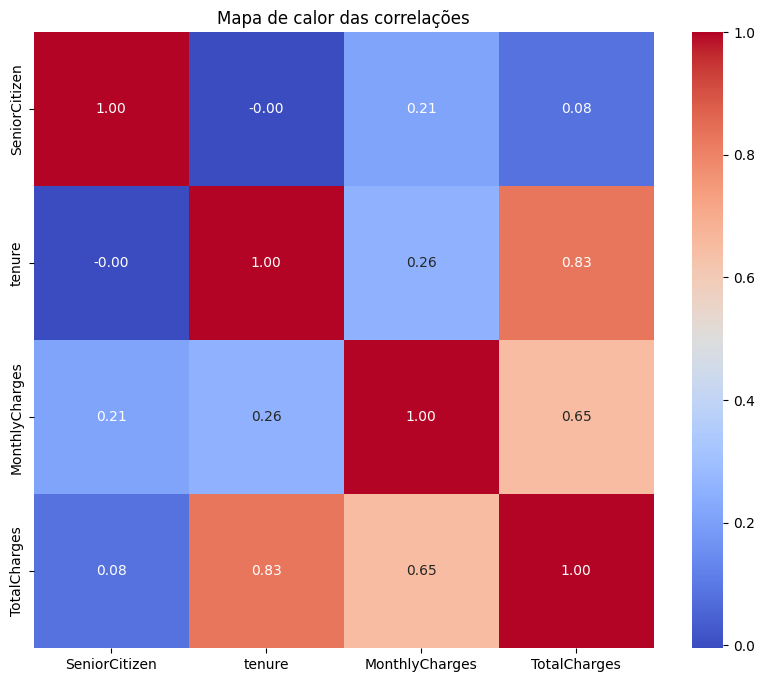

In [18]:
numericdfTrainFoldOne = dfTrainFoldOne.select_dtypes(include=["number"])

correlation_matrix = numericdfTrainFoldOne.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de calor das correlações")
plt.show()

In [19]:
dfTrainFoldOne.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6665,Male,0,Yes,Yes,43,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,No,Credit card (automatic),29.30,1224.05,No
6156,Female,1,No,No,26,Yes,No,Fiber optic,Yes,No,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),85.80,2193.65,No
4846,Male,0,No,No,7,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),69.15,488.65,No
2714,Female,0,No,No,54,Yes,Yes,Fiber optic,No,No,Yes,Yes,No,Yes,Two year,Yes,Bank transfer (automatic),95.10,5064.85,No
4215,Male,0,Yes,No,72,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,108.20,7840.60,No


<Axes: xlabel='Churn', ylabel='count'>

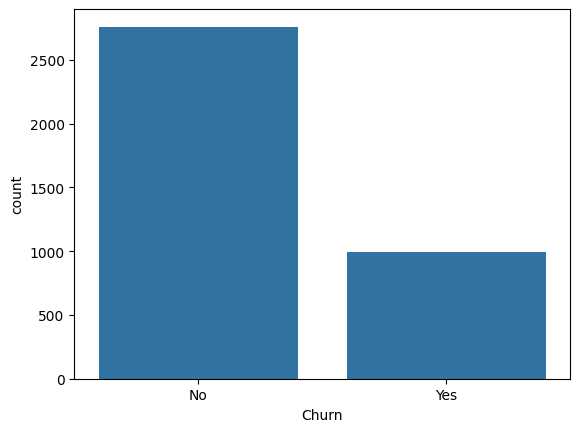

In [20]:
sns.countplot(x='Churn', data=dfTrainFoldOne)

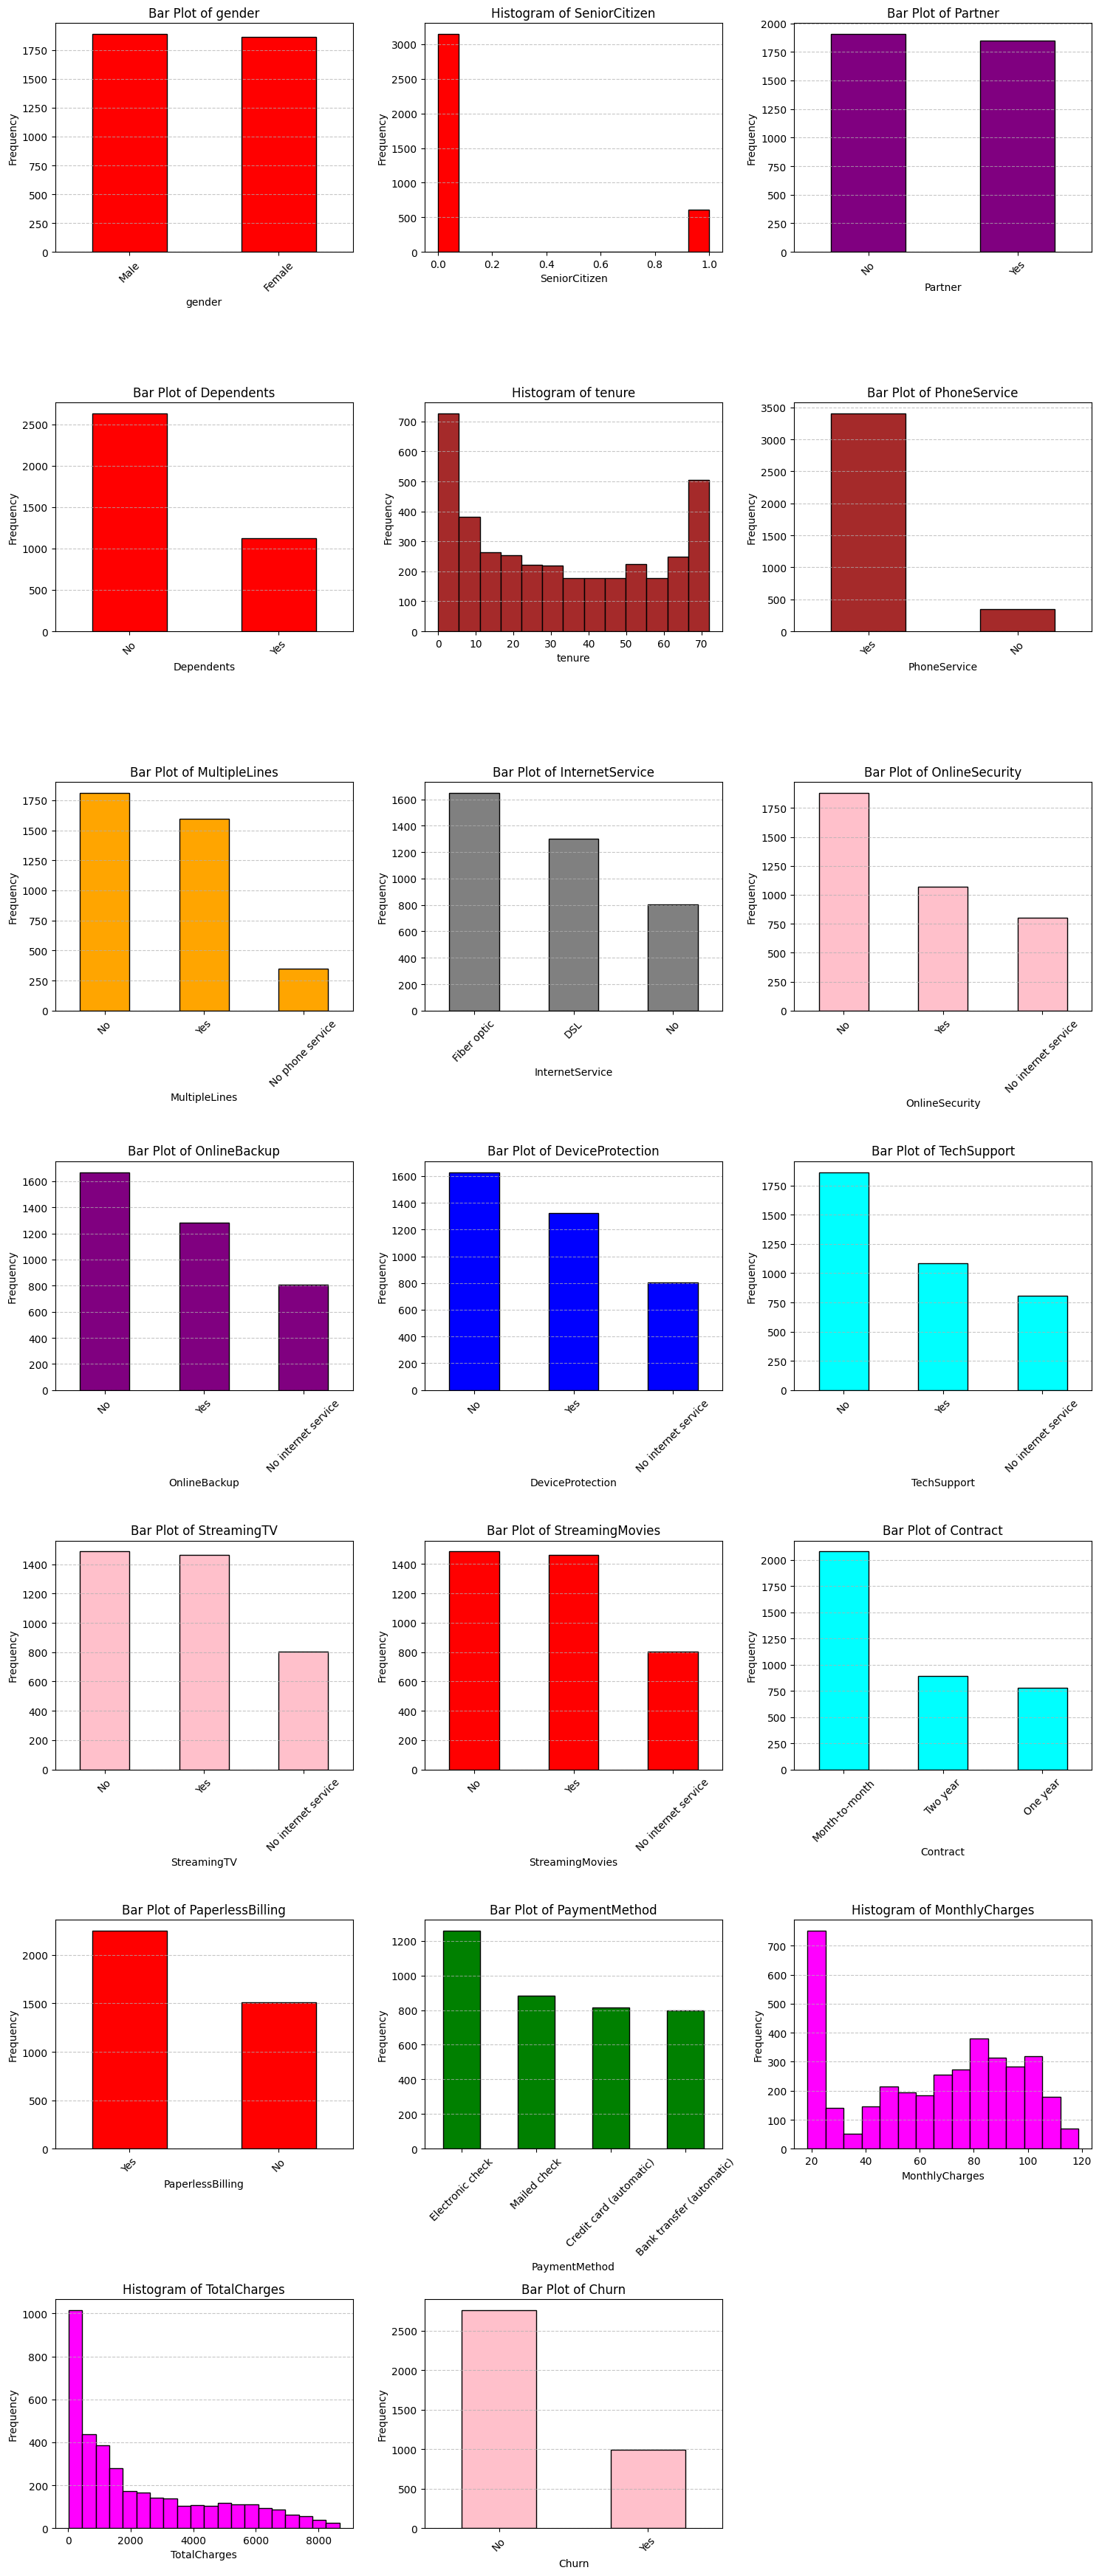

In [21]:
plotHistogram(dfTrainFoldOne)

Como podemos observar, as variáveis númericas 'tenure', 'MonthlyCharges' e 'TotallyCharges' possuem um grande variação de valores e, por isso trazem a necessidade colocar em faixas, como mostrado abaixo:

In [22]:
maxTenure, maxMonthlyCharges, maxTotallyCharges = dfTrainFoldOne['tenure'].max(), dfTrainFoldOne['MonthlyCharges'].max(), dfTrainFoldOne['TotalCharges'].max()
print(maxTenure)
print(maxMonthlyCharges)
print(maxTotallyCharges)


72
118.75
8672.45


# 4. Tratamento dos Dados

## 4.1 Tratamento de Dados Nulos

In [23]:
dfTrainFoldOne.isnull().sum() / len(dfTrainFoldOne) * 100

gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
tenure              0.000000
PhoneService        0.000000
MultipleLines       0.000000
InternetService     0.000000
OnlineSecurity      0.000000
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
Contract            0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.159744
Churn               0.000000
dtype: float64

### *Median Imputation*

Como aproximadamente `16%` da coluna `TotalCharges` não possui valores, optamos por utilizar a *median imputation* para preencher os valores.

In [24]:
dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = fix_missing_values_median(dfTrainFoldOne.copy(), dfValFoldOne.copy(), dfTestFoldOne.copy(), "TotalCharges")

/tmp/ipykernel_95539/332783124.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df_copy[column].fillna(median_value, inplace=True)
/tmp/ipykernel_95539/332783124.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [25]:
dfTrainFoldOne.isnull().sum() / len(dfTrainFoldOne) * 100

gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [26]:
dfTestFoldOne.isnull().sum() / len(dfTestFoldOne) * 100

gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [27]:
dfValFoldOne.isnull().sum() / len(dfValFoldOne) * 100

gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

## 4.2 Tratamento de Outliers

/tmp/ipykernel_95539/2271309273.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(numeric_columns, rotation=45, ha='right', fontsize=12)


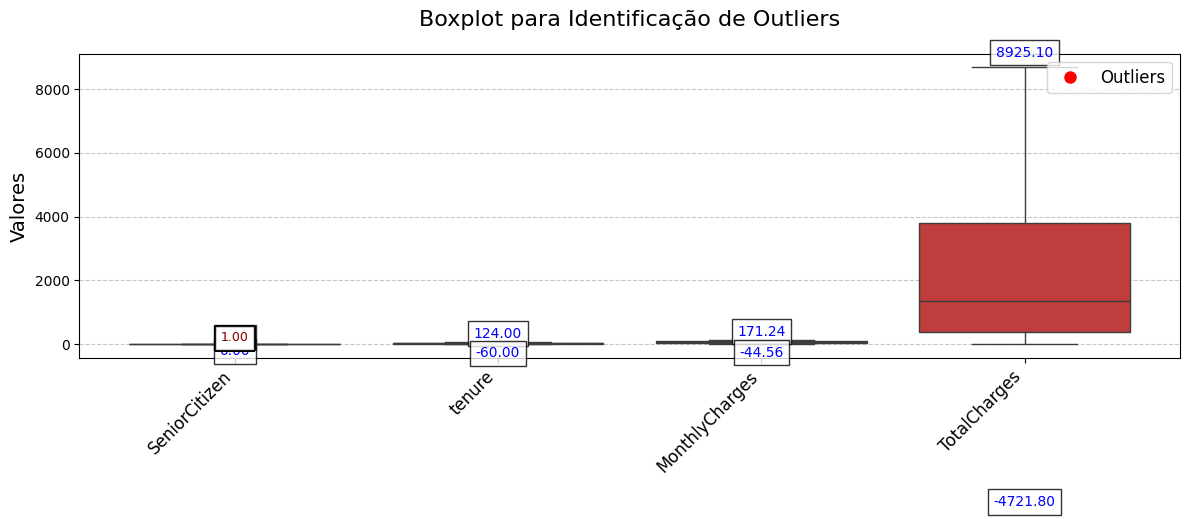

In [28]:
plot_outliers(dfTrainFoldOne)

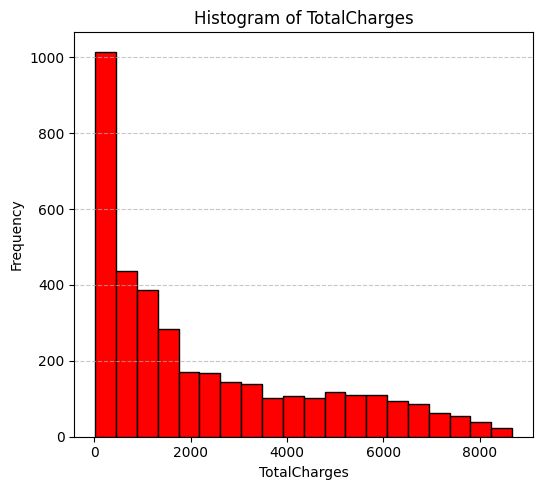

In [29]:
plotHistogram(dfTrainFoldOne['TotalCharges'])

In [30]:
dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = remove_outliers(dfTrainFoldOne.copy(), dfValFoldOne.copy(), dfTestFoldOne.copy(), "TotalCharges")

In [31]:
dfTrainFoldOne["tenure"].isnull().sum()

0

In [32]:
dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = bin_columns(dfTrainFoldOne.copy(), dfValFoldOne.copy(), dfTestFoldOne.copy(), "tenure")

In [33]:
dfTrainFoldOne["tenure"].isnull().sum()

0

## 4.3 Normalização de dados numéricos com Min-Max

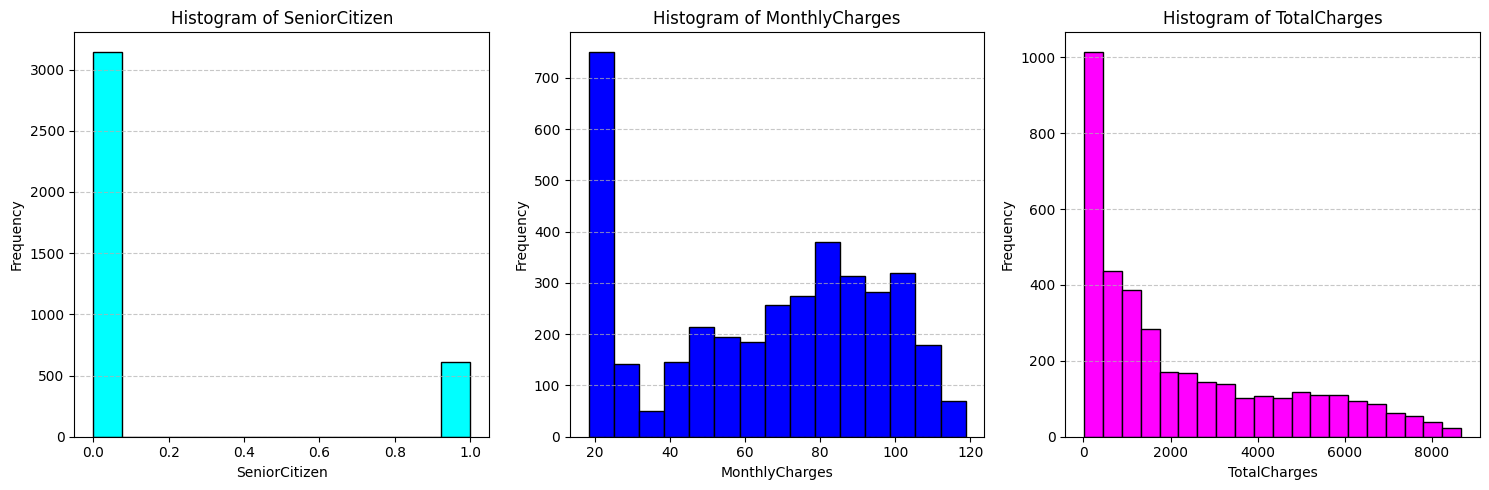

In [34]:
numeric_cols = dfTrainFoldOne.select_dtypes(include=['number'])
plotHistogram(numeric_cols)

In [35]:
dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = normalize_data(dfTrainFoldOne.copy(), dfValFoldOne.copy(), dfTestFoldOne.copy())

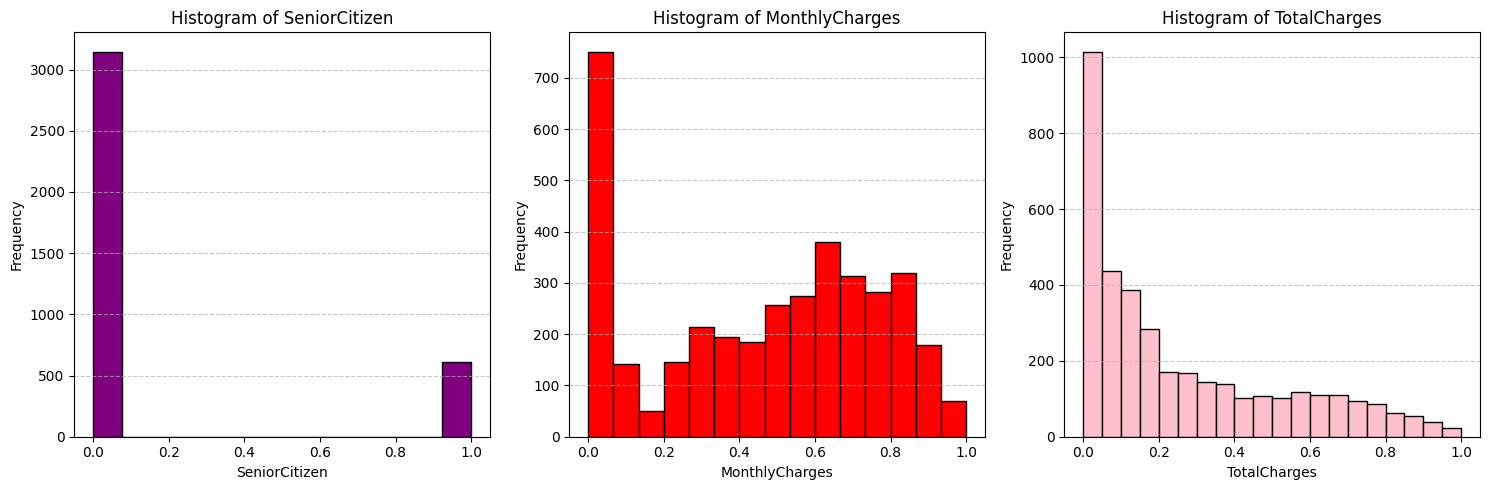

In [36]:
plotHistogram(dfTrainFoldOne[numeric_cols.columns])

## 4.4 Tratamento de Variáveis Categóricas

A seguir, transformamos as variáveis categóricas em numéricas. Para as colunas binárias, mapeamos os valores "Yes" e "No" para 1 e 0, respectivamente. Em seguida, aplicamos **One-Hot Encoding** a todas as variáveis categóricas(não necessário utilizar a codificação de bits, pois o máximo de valores únicos em uma categoria é 4), **exceto "Contract"**, pois ela possui um aspecto ordinal e deve ser codificada de forma diferente.  

Além disso, a variável numérica **"tenure"** é convertida em faixas, representando diferentes períodos de tempo, e depois transformada em valores numéricos ordinais.  

Essas transformações são realizadas nas funções **`preprocess_categorical_data`** (para variáveis categóricas) e **`bin_and_encode`** (para a variável "tenure").

In [37]:
dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = preprocess_categorical_data(dfTrainFoldOne.copy(), dfValFoldOne.copy(), dfTestFoldOne.copy())

In [38]:
dfTrainFoldOne.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes
6665,0.0,1,1,2.0,0,0.0,0,0.108620,0.139257,0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
6156,1.0,0,0,1.0,1,0.0,1,0.671649,0.251304,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4846,0.0,0,0,0.0,1,0.0,0,0.505730,0.054273,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2714,0.0,0,0,2.0,1,2.0,1,0.764325,0.583103,0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4215,0.0,1,0,3.0,1,2.0,1,0.894868,0.903871,0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


## 4.4 Tratamentos nos *folds* `k=2` e `k=3`

### `k=2`

In [39]:
dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = fix_missing_values_median(dfTrainFoldTwo.copy(), dfValFoldTwo.copy(), dfTestFoldTwo.copy(), "TotalCharges")

/tmp/ipykernel_95539/332783124.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df_copy[column].fillna(median_value, inplace=True)
/tmp/ipykernel_95539/332783124.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [40]:
dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = remove_outliers(dfTrainFoldTwo.copy(), dfValFoldTwo.copy(), dfTestFoldTwo.copy(), "TotalCharges")

In [41]:
dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = normalize_data(dfTrainFoldTwo.copy(), dfValFoldTwo.copy(), dfTestFoldTwo.copy())

In [42]:
dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = bin_columns(dfTrainFoldTwo.copy(), dfValFoldTwo.copy(), dfTestFoldTwo.copy(), "tenure")
dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = preprocess_categorical_data(dfTrainFoldTwo.copy(), dfValFoldTwo.copy(), dfTestFoldTwo.copy())

### `k=3`

In [43]:
dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = fix_missing_values_median(dfTrainFoldThree.copy(), dfValFoldThree.copy(), dfTestFoldThree.copy(), "TotalCharges")

/tmp/ipykernel_95539/332783124.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df_copy[column].fillna(median_value, inplace=True)
/tmp/ipykernel_95539/332783124.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [44]:
dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = remove_outliers(dfTrainFoldThree.copy(), dfValFoldThree.copy(), dfTestFoldThree.copy(), "TotalCharges")

In [45]:
dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = normalize_data(dfTrainFoldThree.copy(), dfValFoldThree.copy(), dfTestFoldThree.copy())

In [46]:
dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = bin_columns(dfTrainFoldThree.copy(), dfValFoldThree.copy(), dfTestFoldThree.copy(), "tenure")
dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = preprocess_categorical_data(dfTrainFoldThree.copy(), dfValFoldThree.copy(), dfTestFoldThree.copy())

# 5. Experimentos

## *Random Forest*

### Parâmetros que serão variados
- Número de árvores (`n_estimators`)
- Profundidade máxima (`max_depth`)
- Número mínimo de amostras para dividir um nó (`min_samples_split`)
- Critério de divisão (`criterion`)

In [48]:
#Fold One
X_train_fold_one = dfTrainFoldOne.drop("Churn", axis=1)
y_train_fold_one = dfTrainFoldOne["Churn"]
X_test_fold_one = dfTestFoldOne.drop("Churn", axis=1)
y_test_fold_one = dfTestFoldOne["Churn"]
X_val_fold_one = dfValFoldOne.drop("Churn", axis=1)
y_val_fold_one = dfValFoldOne["Churn"]
#Fold Two
X_train_fold_two = dfTrainFoldTwo.drop("Churn", axis=1)
y_train_fold_two = dfTrainFoldTwo["Churn"]
X_test_fold_two = dfTestFoldTwo.drop("Churn", axis=1)
y_test_fold_two = dfTestFoldTwo["Churn"]
X_val_fold_two = dfValFoldTwo.drop("Churn", axis=1)
y_val_fold_two = dfValFoldTwo["Churn"]
#Fold Three
X_train_fold_three = dfTrainFoldThree.drop("Churn", axis=1)
y_train_fold_three = dfTrainFoldThree["Churn"]
X_test_fold_three = dfTestFoldThree.drop("Churn", axis=1)
y_test_fold_three = dfTestFoldThree["Churn"]
X_val_fold_three = dfValFoldThree.drop("Churn", axis=1)
y_val_fold_three = dfValFoldThree["Churn"]

### Otimização com Optuna

In [49]:
def objective_RF(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    # testar com o roc-auc
    score = cross_val_score(model, X_train_fold_one, y_train_fold_one, cv=3, scoring="f1").mean()
    return score

In [ ]:
study_RF = optuna.create_study(direction="maximize")  
study_RF.optimize(objective_RF, n_trials=50)  

[I 2025-04-13 18:52:10,980] A new study created in memory with name: no-name-4df6e805-21bb-4d44-b275-9a7caa6b7b12
[I 2025-04-13 18:52:13,361] Trial 0 finished with value: 0.5976889070328504 and parameters: {'n_estimators': 297, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5976889070328504.
[I 2025-04-13 18:52:14,161] Trial 1 finished with value: 0.5865396594404598 and parameters: {'n_estimators': 91, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 0 with value: 0.5976889070328504.
[I 2025-04-13 18:52:15,938] Trial 2 finished with value: 0.5929913581461765 and parameters: {'n_estimators': 232, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 0 with value: 0.5976889070328504.
[I 2025-04-13 18:52:17,474] Trial 3 finished with value: 0.5891579139775875 and parameters: {'n_estimators': 187, 'max_depth': 12, 'min_samp

In [ ]:
print("Melhores hiperparâmetros:", study_RF.best_params)

### Treinamento do Modelo

#### Fold One

In [ ]:
print("Random Forest Fold One: \n")
best_params_RF = study_RF.best_params
final_model = RandomForestClassifier(**best_params_RF, random_state=42, n_jobs=-1)
final_model.fit(X_train_fold_one, y_train_fold_one)

#Estatísticas para o Conjunto de Validação
y_pred = final_model.predict(X_val_fold_one)
accuracy_RF = accuracy_score(y_val_fold_one, y_pred)
f1_value_RF = f1_score(y_val_fold_one, y_pred)
y_probs = final_model.predict_proba(X_val_fold_one)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_val_fold_one == 1], y_probs[y_val_fold_one == 0])

print("Acurácia final no conjunto de validação: {:.2f}%".format(accuracy_RF * 100))
print("F1-Score final no conjunto de validação: {:.2f}%".format(f1_value_RF * 100))
print("KS no conjunto de validação: {:.4f}%".format(ks_statistic * 100))

#Estatísticas para o Conjunto de Teste
y_pred = final_model.predict(X_test_fold_one)
accuracy_RF = accuracy_score(y_test_fold_one, y_pred)
f1_value_RF = f1_score(y_test_fold_one, y_pred)
y_probs = final_model.predict_proba(X_test_fold_one)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_test_fold_one == 1], y_probs[y_test_fold_one == 0])

print("\n\nAcurácia final no conjunto de teste: {:.2f}%".format(accuracy_RF * 100))
print("F1-Score final no conjunto de teste: {:.2f}%".format(f1_value_RF * 100))
print("KS no conjunto de teste: {:.4f}%".format(ks_statistic * 100))

#### Fold Two

In [ ]:
print("Random Forest Fold Two: \n")
best_params_RF = study_RF.best_params
final_model = RandomForestClassifier(**best_params_RF, random_state=42, n_jobs=-1)
final_model.fit(X_train_fold_two, y_train_fold_two)

#Estatísticas para o Conjunto de Validação
y_pred = final_model.predict(X_val_fold_two)
accuracy_RF = accuracy_score(y_val_fold_two, y_pred)
f1_value_RF = f1_score(y_val_fold_two, y_pred)
y_probs = final_model.predict_proba(X_val_fold_two)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_val_fold_two == 1], y_probs[y_val_fold_two == 0])

print("Acurácia final no conjunto de validação: {:.2f}%".format(accuracy_RF * 100))
print("F1-Score final no conjunto de validação: {:.2f}%".format(f1_value_RF * 100))
print("KS no conjunto de validação: {:.4f}%".format(ks_statistic * 100))

#Estatísticas para o Conjunto de Teste
y_pred = final_model.predict(X_test_fold_two)
accuracy_RF = accuracy_score(y_test_fold_two, y_pred)
f1_value_RF = f1_score(y_test_fold_two, y_pred)
y_probs = final_model.predict_proba(X_test_fold_two)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_test_fold_two == 1], y_probs[y_test_fold_two == 0])

print("\n\nAcurácia final no conjunto de teste: {:.2f}%".format(accuracy_RF * 100))
print("F1-Score final no conjunto de teste: {:.2f}%".format(f1_value_RF * 100))
print("KS no conjunto de teste: {:.4f}%".format(ks_statistic * 100))

#### Fold Three

In [53]:
print("Random Forest Fold Three: \n")
best_params_RF = study_RF.best_params
final_model = RandomForestClassifier(**best_params_RF, random_state=42, n_jobs=-1)
final_model.fit(X_train_fold_three, y_train_fold_three)

#Estatísticas para o Conjunto de Validação
y_pred = final_model.predict(X_val_fold_three)
accuracy_RF = accuracy_score(y_val_fold_three, y_pred)
f1_value_RF = f1_score(y_val_fold_three, y_pred)
y_probs = final_model.predict_proba(X_val_fold_three)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_val_fold_three == 1], y_probs[y_val_fold_three == 0])

print("Acurácia final no conjunto de validação: {:.2f}%".format(accuracy_RF * 100))
print("F1-Score final no conjunto de validação: {:.2f}%".format(f1_value_RF * 100))
print("KS no conjunto de validação: {:.4f}%".format(ks_statistic * 100))

#Estatísticas para o Conjunto de Teste
y_pred = final_model.predict(X_test_fold_three)
accuracy_RF = accuracy_score(y_test_fold_three, y_pred)
f1_value_RF = f1_score(y_test_fold_three, y_pred)
y_probs = final_model.predict_proba(X_test_fold_three)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_test_fold_three == 1], y_probs[y_test_fold_three == 0])

print("\n\nAcurácia final no conjunto de teste: {:.2f}%".format(accuracy_RF * 100))
print("F1-Score final no conjunto de teste: {:.2f}%".format(f1_value_RF * 100))
print("KS no conjunto de teste: {:.4f}%".format(ks_statistic * 100))

Random Forest Fold Three: 

Acurácia final no conjunto de validação: 79.15%
F1-Score final no conjunto de validação: 55.05%
KS no conjunto de validação: 56.7744%


Acurácia final no conjunto de teste: 80.23%
F1-Score final no conjunto de teste: 57.27%
KS no conjunto de teste: 52.7691%


## MLP

### Parâmetros que serão variados

- Número de camadas
- Número de neurônios
- Taxa de aprendizagem
- Otimização

In [54]:
print("CUDA disponível:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
print("Versão do PyTorch:", torch.__version__)

CUDA disponível: True
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Versão do PyTorch: 2.3.0+cu121


### Otimização com Optuna

In [55]:
def objective_MLP_Cuda(trial):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    n_neurons = trial.suggest_int("n_neurons", 10, 200)
    activation_name = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])
    learning_rate = trial.suggest_float("learning_rate_init", 1e-5, 1e-2, log=True)

    input_size = X_train_fold_one.shape[1]
    output_size = len(np.unique(y_train_fold_one))

    layers = [nn.Linear(input_size, n_neurons)]
    if activation_name == "relu":
        layers.append(nn.ReLU())
    elif activation_name == "tanh":
        layers.append(nn.Tanh())
    elif activation_name == "logistic":
        layers.append(nn.Sigmoid())
    layers.append(nn.Linear(n_neurons, output_size))

    model = nn.Sequential(*layers).to(device)

    X_train_tensor = torch.tensor(X_train_fold_one.to_numpy(), dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_fold_one.to_numpy(), dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test_fold_one.to_numpy(), dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test_fold_one.to_numpy(), dtype=torch.long)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, y_pred = torch.max(outputs, 1)

    f1 = f1_score(y_test_tensor.cpu(), y_pred.cpu(), average="macro")
    return f1

In [56]:
study_MLP = optuna.create_study(direction="maximize")
study_MLP.optimize(objective_MLP_Cuda, n_trials=50)

print("Melhores hiperparâmetros:", study_MLP.best_params)

[I 2025-04-13 18:11:26,571] A new study created in memory with name: no-name-f40ac1dd-1e15-4751-a9d2-dbc1ab64efbf
[I 2025-04-13 18:11:28,211] Trial 0 finished with value: 0.4260571987289171 and parameters: {'n_neurons': 95, 'activation': 'tanh', 'learning_rate_init': 0.00010945123466936337}. Best is trial 0 with value: 0.4260571987289171.
[I 2025-04-13 18:11:28,387] Trial 1 finished with value: 0.7352110642981514 and parameters: {'n_neurons': 23, 'activation': 'tanh', 'learning_rate_init': 0.008155691450001674}. Best is trial 1 with value: 0.7352110642981514.
[I 2025-04-13 18:11:28,564] Trial 2 finished with value: 0.4260571987289171 and parameters: {'n_neurons': 44, 'activation': 'logistic', 'learning_rate_init': 0.00010234408491963768}. Best is trial 1 with value: 0.7352110642981514.
[I 2025-04-13 18:11:28,799] Trial 3 finished with value: 0.7270382661422484 and parameters: {'n_neurons': 124, 'activation': 'relu', 'learning_rate_init': 0.00046768793595232237}. Best is trial 1 with va

Melhores hiperparâmetros: {'n_neurons': 168, 'activation': 'tanh', 'learning_rate_init': 0.0031911981995923016}


### Treinamento do Modelo

#### Fold One

In [57]:
print("MLP Fold One: \n")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train_fold_one.to_numpy(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_fold_one.to_numpy(), dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_fold_one.to_numpy(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_fold_one.to_numpy(), dtype=torch.long)
X_val_tensor = torch.tensor(X_val_fold_one.to_numpy(), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_fold_one.to_numpy(), dtype=torch.long).to(device)

best_params_MLP = study_MLP.best_params
n_neurons = best_params_MLP["n_neurons"]
activation_name = best_params_MLP["activation"]
learning_rate = best_params_MLP["learning_rate_init"]

input_size = X_train_fold_one.shape[1]
output_size = len(torch.unique(y_train_tensor))

layers = [nn.Linear(input_size, n_neurons)]
if activation_name == "relu":
    layers.append(nn.ReLU())
elif activation_name == "tanh":
    layers.append(nn.Tanh())
elif activation_name == "logistic":
    layers.append(nn.Sigmoid())
layers.append(nn.Linear(n_neurons, output_size))

model = nn.Sequential(*layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(100):  # Pode ajustar epochs
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_acc = (val_preds == y_val_tensor).float().mean().item()
    
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}")

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)  
    probabilities = torch.softmax(outputs, dim=1)  
    y_probs = probabilities[:, 1].cpu().numpy()  
    y_pred = torch.argmax(outputs, dim=1)
    
y_pred_cpu = y_pred.cpu().numpy()
y_test_cpu = y_test_tensor.cpu().numpy()

acc = accuracy_score(y_test_cpu, y_pred_cpu)
f1 = f1_score(y_test_cpu, y_pred_cpu, average="macro")

ks_statistic, _ = ks_2samp(y_probs[y_test_cpu == 1], y_probs[y_test_cpu == 0])

print("\n\nAcurácia final: {:.2f}%".format(acc * 100))
print("F1-Score final: {:.2f}%".format(f1 * 100))
print("KS: {:.4f}%".format(ks_statistic*100))

MLP Fold One: 

Epoch 1, Train Loss: 0.8245, Val Loss: 0.6408, Val Acc: 0.6869
Epoch 2, Train Loss: 0.6407, Val Loss: 0.5499, Val Acc: 0.7391
Epoch 3, Train Loss: 0.5546, Val Loss: 0.5224, Val Acc: 0.7391
Epoch 4, Train Loss: 0.5301, Val Loss: 0.5161, Val Acc: 0.7391
Epoch 5, Train Loss: 0.5247, Val Loss: 0.5090, Val Acc: 0.7391
Epoch 6, Train Loss: 0.5166, Val Loss: 0.4953, Val Acc: 0.7391
Epoch 7, Train Loss: 0.5008, Val Loss: 0.4773, Val Acc: 0.7391
Epoch 8, Train Loss: 0.4802, Val Loss: 0.4599, Val Acc: 0.7593
Epoch 9, Train Loss: 0.4602, Val Loss: 0.4479, Val Acc: 0.7859
Epoch 10, Train Loss: 0.4459, Val Loss: 0.4441, Val Acc: 0.7934
Epoch 11, Train Loss: 0.4404, Val Loss: 0.4479, Val Acc: 0.7796
Epoch 12, Train Loss: 0.4428, Val Loss: 0.4549, Val Acc: 0.7689
Epoch 13, Train Loss: 0.4489, Val Loss: 0.4603, Val Acc: 0.7678
Epoch 14, Train Loss: 0.4532, Val Loss: 0.4612, Val Acc: 0.7678
Epoch 15, Train Loss: 0.4531, Val Loss: 0.4580, Val Acc: 0.7700
Epoch 16, Train Loss: 0.4487, Val

#### Fold Two

In [58]:
print("MLP Fold Two: \n")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train_fold_two.to_numpy(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_fold_two.to_numpy(), dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_fold_two.to_numpy(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_fold_two.to_numpy(), dtype=torch.long)
X_val_tensor = torch.tensor(X_val_fold_two.to_numpy(), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_fold_two.to_numpy(), dtype=torch.long).to(device)

best_params_MLP = study_MLP.best_params
n_neurons = best_params_MLP["n_neurons"]
activation_name = best_params_MLP["activation"]
learning_rate = best_params_MLP["learning_rate_init"]

input_size = X_train_fold_two.shape[1]
output_size = len(torch.unique(y_train_tensor))

layers = [nn.Linear(input_size, n_neurons)]
if activation_name == "relu":
    layers.append(nn.ReLU())
elif activation_name == "tanh":
    layers.append(nn.Tanh())
elif activation_name == "logistic":
    layers.append(nn.Sigmoid())
layers.append(nn.Linear(n_neurons, output_size))

model = nn.Sequential(*layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(100):  # Pode ajustar epochs
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_acc = (val_preds == y_val_tensor).float().mean().item()
    
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}")

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)  
    probabilities = torch.softmax(outputs, dim=1)  
    y_probs = probabilities[:, 1].cpu().numpy()
    y_pred = torch.argmax(outputs, dim=1)

y_pred_cpu = y_pred.cpu().numpy()
y_test_cpu = y_test_tensor.cpu().numpy()

acc = accuracy_score(y_test_cpu, y_pred_cpu)
f1 = f1_score(y_test_cpu, y_pred_cpu, average="macro")

ks_statistic, _ = ks_2samp(y_probs[y_test_cpu == 1], y_probs[y_test_cpu == 0])

print("\n\nAcurácia final: {:.2f}%".format(acc * 100))
print("F1-Score final: {:.2f}%".format(f1 * 100))
print("KS: {:.4f}%".format(ks_statistic * 100))

MLP Fold Two: 

Epoch 1, Train Loss: 0.6985, Val Loss: 0.5979, Val Acc: 0.7370
Epoch 2, Train Loss: 0.5981, Val Loss: 0.5551, Val Acc: 0.7380
Epoch 3, Train Loss: 0.5534, Val Loss: 0.5367, Val Acc: 0.7380
Epoch 4, Train Loss: 0.5328, Val Loss: 0.5236, Val Acc: 0.7380
Epoch 5, Train Loss: 0.5176, Val Loss: 0.5086, Val Acc: 0.7380
Epoch 6, Train Loss: 0.5009, Val Loss: 0.4918, Val Acc: 0.7380
Epoch 7, Train Loss: 0.4828, Val Loss: 0.4761, Val Acc: 0.7412
Epoch 8, Train Loss: 0.4660, Val Loss: 0.4648, Val Acc: 0.7646
Epoch 9, Train Loss: 0.4539, Val Loss: 0.4595, Val Acc: 0.7838
Epoch 10, Train Loss: 0.4479, Val Loss: 0.4590, Val Acc: 0.7902
Epoch 11, Train Loss: 0.4467, Val Loss: 0.4597, Val Acc: 0.7881
Epoch 12, Train Loss: 0.4467, Val Loss: 0.4587, Val Acc: 0.7806
Epoch 13, Train Loss: 0.4449, Val Loss: 0.4554, Val Acc: 0.7849
Epoch 14, Train Loss: 0.4408, Val Loss: 0.4515, Val Acc: 0.7849
Epoch 15, Train Loss: 0.4361, Val Loss: 0.4488, Val Acc: 0.7849
Epoch 16, Train Loss: 0.4325, Val

#### Fold Three

In [59]:
print("MLP Fold Three: \n")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train_fold_three.to_numpy(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_fold_three.to_numpy(), dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_fold_three.to_numpy(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_fold_three.to_numpy(), dtype=torch.long)
X_val_tensor = torch.tensor(X_val_fold_three.to_numpy(), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_fold_three.to_numpy(), dtype=torch.long).to(device)

best_params_MLP = study_MLP.best_params
n_neurons = best_params_MLP["n_neurons"]
activation_name = best_params_MLP["activation"]
learning_rate = best_params_MLP["learning_rate_init"]

input_size = X_train_fold_two.shape[1]
output_size = len(torch.unique(y_train_tensor))

layers = [nn.Linear(input_size, n_neurons)]
if activation_name == "relu":
    layers.append(nn.ReLU())
elif activation_name == "tanh":
    layers.append(nn.Tanh())
elif activation_name == "logistic":
    layers.append(nn.Sigmoid())
layers.append(nn.Linear(n_neurons, output_size))

model = nn.Sequential(*layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(100):  # Pode ajustar epochs
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_acc = (val_preds == y_val_tensor).float().mean().item()
    
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}")

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)  
    probabilities = torch.softmax(outputs, dim=1)  
    y_probs = probabilities[:, 1].cpu().numpy()
    y_pred = torch.argmax(outputs, dim=1)

y_pred_cpu = y_pred.cpu().numpy()
y_test_cpu = y_test_tensor.cpu().numpy()

acc = accuracy_score(y_test_cpu, y_pred_cpu)
f1 = f1_score(y_test_cpu, y_pred_cpu, average="macro")

ks_statistic, _ = ks_2samp(y_probs[y_test_cpu == 1], y_probs[y_test_cpu == 0])

print("\n\nAcurácia final: {:.2f}%".format(acc * 100))
print("F1-Score final: {:.2f}%".format(f1 * 100))
print("KS: {:.4f}%".format(ks_statistic * 100))

MLP Fold Three: 

Epoch 1, Train Loss: 0.6458, Val Loss: 0.5761, Val Acc: 0.7298
Epoch 2, Train Loss: 0.5752, Val Loss: 0.5419, Val Acc: 0.7298
Epoch 3, Train Loss: 0.5400, Val Loss: 0.5181, Val Acc: 0.7298
Epoch 4, Train Loss: 0.5162, Val Loss: 0.4959, Val Acc: 0.7298
Epoch 5, Train Loss: 0.4946, Val Loss: 0.4755, Val Acc: 0.7351
Epoch 6, Train Loss: 0.4756, Val Loss: 0.4604, Val Acc: 0.7755
Epoch 7, Train Loss: 0.4623, Val Loss: 0.4524, Val Acc: 0.7872
Epoch 8, Train Loss: 0.4563, Val Loss: 0.4494, Val Acc: 0.7883
Epoch 9, Train Loss: 0.4551, Val Loss: 0.4473, Val Acc: 0.7894
Epoch 10, Train Loss: 0.4541, Val Loss: 0.4442, Val Acc: 0.7926
Epoch 11, Train Loss: 0.4514, Val Loss: 0.4412, Val Acc: 0.7936
Epoch 12, Train Loss: 0.4482, Val Loss: 0.4401, Val Acc: 0.7947
Epoch 13, Train Loss: 0.4465, Val Loss: 0.4408, Val Acc: 0.7904
Epoch 14, Train Loss: 0.4468, Val Loss: 0.4417, Val Acc: 0.7872
Epoch 15, Train Loss: 0.4475, Val Loss: 0.4410, Val Acc: 0.7851
Epoch 16, Train Loss: 0.4470, V

## *Gradient Boosting*

### Parâmetros que serão variados
- Número de estimadores
- Taxa de aprendizagem
- Profundidade Máxima
- Mínimo de amostras para divisão
- Mínimo de amostras na folha
- Fração de amostras

In [60]:
#Fold One
X_train_fold_one = dfTrainFoldOne.drop("Churn", axis=1)
y_train_fold_one = dfTrainFoldOne["Churn"]
X_test_fold_one = dfTestFoldOne.drop("Churn", axis=1)
y_test_fold_one = dfTestFoldOne["Churn"]
#Fold Two
X_train_fold_two = dfTrainFoldTwo.drop("Churn", axis=1)
y_train_fold_two = dfTrainFoldTwo["Churn"]
X_test_fold_two = dfTestFoldTwo.drop("Churn", axis=1)
y_test_fold_two = dfTestFoldTwo["Churn"]
#Fold Three
X_train_fold_three = dfTrainFoldThree.drop("Churn", axis=1)
y_train_fold_three = dfTrainFoldThree["Churn"]
X_test_fold_three = dfTestFoldThree.drop("Churn", axis=1)
y_test_fold_three = dfTestFoldThree["Churn"]

### Otimização com Optuna

In [61]:
def objective_GB(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)

    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        random_state=42
    )

    score = cross_val_score(model, X_train_fold_one, y_train_fold_one, cv=3, scoring="f1").mean()
    return score

In [62]:
study_GB = optuna.create_study(direction="maximize")
study_GB.optimize(objective_GB, n_trials=50)

[I 2025-04-13 18:11:37,543] A new study created in memory with name: no-name-908bc510-20bf-4445-af68-62360d7b7b43
[I 2025-04-13 18:11:46,736] Trial 0 finished with value: 0.5496585097760613 and parameters: {'n_estimators': 194, 'learning_rate': 0.01019711562845665, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 10, 'subsample': 0.827049028606003}. Best is trial 0 with value: 0.5496585097760613.
[I 2025-04-13 18:11:52,526] Trial 1 finished with value: 0.567652898613145 and parameters: {'n_estimators': 169, 'learning_rate': 0.056370245941307476, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 4, 'subsample': 0.9447011930324531}. Best is trial 1 with value: 0.567652898613145.
[I 2025-04-13 18:12:01,436] Trial 2 finished with value: 0.5580928238128423 and parameters: {'n_estimators': 159, 'learning_rate': 0.09165777868129975, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 10, 'subsample': 0.8720005249251938}. Best is trial 1 with value: 0.56765289861

### Treinamento do Modelo

#### Fold One

In [63]:
print("Gradient Boosting Fold One: \n")
best_params_GB = study_GB.best_params

final_model = GradientBoostingClassifier(
    **best_params_GB,
    random_state=42
)

final_model.fit(X_train_fold_one, y_train_fold_one)

y_pred = final_model.predict(X_test_fold_one)
accuracy_GB = accuracy_score(y_test_fold_one, y_pred)
f1_value_GB = f1_score(y_test_fold_one, y_pred)
y_probs = final_model.predict_proba(X_test_fold_one)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_test_fold_one == 1], y_probs[y_test_fold_one == 0])

print("Acurácia final: {:.2f}%".format(accuracy_GB * 100))
print("F1-Score final: {:.2f}%".format(f1_value_GB * 100))
print("KS: {:.4f}%".format(ks_statistic * 100))

Gradient Boosting Fold One: 

Acurácia final: 80.83%
F1-Score final: 58.02%
KS: 53.1976%


#### Fold Two

In [64]:
print("Gradient Boosting Fold Two: \n")
best_params_GB = study_GB.best_params

final_model = GradientBoostingClassifier(
    **best_params_GB,
    random_state=42
)

final_model.fit(X_train_fold_two, y_train_fold_two)

y_pred = final_model.predict(X_test_fold_two)
accuracy_GB = accuracy_score(y_test_fold_two, y_pred)
f1_value_GB = f1_score(y_test_fold_two, y_pred)
y_probs = final_model.predict_proba(X_test_fold_two)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_test_fold_two == 1], y_probs[y_test_fold_two == 0])

print("Acurácia final: {:.2f}%".format(accuracy_GB * 100))
print("F1-Score final: {:.2f}%".format(f1_value_GB * 100))
print("KS: {:.4f}%".format(ks_statistic * 100))

Gradient Boosting Fold Two: 

Acurácia final: 78.83%
F1-Score final: 55.74%
KS: 52.5472%


#### Fold Three

In [65]:
print("Gradient Boosting Fold Three: \n")
best_params_GB = study_GB.best_params

final_model = GradientBoostingClassifier(
    **best_params_GB,
    random_state=42
)

final_model.fit(X_train_fold_three, y_train_fold_three)

y_pred = final_model.predict(X_test_fold_three)
accuracy_GB = accuracy_score(y_test_fold_three, y_pred)
f1_value_GB = f1_score(y_test_fold_three, y_pred)
y_probs = final_model.predict_proba(X_test_fold_three)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_test_fold_three == 1], y_probs[y_test_fold_three == 0])

print("Acurácia final: {:.2f}%".format(accuracy_GB * 100))
print("F1-Score final: {:.2f}%".format(f1_value_GB * 100))
print("KS: {:.4f}%".format(ks_statistic * 100))

Gradient Boosting Fold Three: 

Acurácia final: 80.53%
F1-Score final: 59.52%
KS: 52.5996%


## KAN

### Parâmetros que serão variados

In [47]:
# ==============================================================================
# START OF KAN + OPTUNA (Maximizing KS) + FINAL TRAINING/EVALUATION BLOCK
# ==============================================================================
# This block assumes dfTrainFoldOne, dfValFoldOne, dfTestFoldOne (and y_...)
# have already been loaded and preprocessed as per the steps earlier in your
# projeto_churn.ipynb notebook.

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import optuna
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import ks_2samp
from kan import KAN # Import KAN
import gc # Garbage collector

# --- Ensure target variable 'Churn' is separated ---
# (This should ideally happen right after preprocessing and before this block,
# but we'll redefine X/y here for clarity based on the notebook structure)

# Fold One Data Separation (assuming 'Churn' is the target column name)
X_train_fold_one = dfTrainFoldOne.drop("Churn", axis=1)
y_train_fold_one = dfTrainFoldOne["Churn"]
X_test_fold_one = dfTestFoldOne.drop("Churn", axis=1)
y_test_fold_one = dfTestFoldOne["Churn"]
X_val_fold_one = dfValFoldOne.drop("Churn", axis=1)
y_val_fold_one = dfValFoldOne["Churn"]

# --- 2. Optuna Objective Function for KAN (Maximize KS) ---                  # <--- MODIFIED
print("\n--- Defining Optuna Objective Function for KAN (Maximize KS) ---") # <--- MODIFIED
def objective_KAN_Cuda_KS(trial):                                             # <--- Renamed for clarity
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # KAN Hyperparameters to tune
    hidden_neurons = trial.suggest_int("hidden_neurons", 5, 50, step=5)
    grid_size = trial.suggest_int("grid_size", 3, 10)
    spline_order = trial.suggest_int("spline_order", 1, 4) # k=3 is often recommended
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True)

    # --- Data Preparation within Objective ---
    X_train_np = X_train_fold_one.values if isinstance(X_train_fold_one, pd.DataFrame) else X_train_fold_one
    y_train_np = y_train_fold_one.values if isinstance(y_train_fold_one, pd.Series) else y_train_fold_one
    X_test_np = X_test_fold_one.values if isinstance(X_test_fold_one, pd.DataFrame) else X_test_fold_one
    y_test_np = y_test_fold_one.values if isinstance(y_test_fold_one, pd.Series) else y_test_fold_one

    input_size = X_train_np.shape[1]
    unique_labels = np.unique(y_train_np)
    output_size = len(unique_labels)

    is_binary = False
    if output_size == 1:
         print(f"Warning: Trial {trial.number}: Only 1 class found. KS score undefined.")
         return 0.0 # Optuna will penalize this
    elif output_size == 2:
        print(f"Trial {trial.number}: Binary classification (Classes: {unique_labels}). Output size = 2.")
        is_binary = True # Flag for KS calculation
    else:
        print(f"Trial {trial.number}: Multi-class classification (Classes: {unique_labels}). KS not applicable.")
        return 0.0 # KS requires binary

    # Define KAN model structure
    width = [input_size, hidden_neurons, output_size]
    model = None
    try:
        model = KAN(width=width, grid=grid_size, k=spline_order, device=device)
    except Exception as e:
        print(f"Error creating KAN model in trial {trial.number}: {e}")
        del model; gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None
        return 0.0

    # Convert data to tensors
    X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_np, dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
    y_test_cpu_np = y_test_np # Keep test labels as numpy array on CPU

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    n_epochs = 50 # Fewer epochs for hyperparameter search

    # Training loop
    try:
        for epoch in range(n_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            if outputs.shape[0] != y_train_tensor.shape[0]:
                 raise ValueError("Output and target shape mismatch during training.")
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()
    except Exception as e:
        print(f"Error during training in trial {trial.number}: {e}")
        del model, X_train_tensor, y_train_tensor, X_test_tensor
        gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None
        return 0.0

    # Evaluation - Calculate KS Statistic                                 # <--- MODIFIED SECTION START
    ks_stat = 0.0 # Default score if KS cannot be computed
    y_probs_test = None
    try:
        model.eval()
        with torch.no_grad():
            outputs_test = model(X_test_tensor)
            if outputs_test is None or not isinstance(outputs_test, torch.Tensor):
                 print(f"Warning: model output is invalid in trial {trial.number}. Skipping eval.")
                 raise ValueError("Invalid model output during evaluation.")

            # Get probabilities for KS statistic
            probabilities_test = torch.softmax(outputs_test, dim=1)
            # Extract probabilities for the positive class (assumed to be label 1)
            y_probs_test = probabilities_test[:, 1].cpu().numpy()

        # Calculate KS statistic
        # Check if both classes exist in the test set for KS calculation
        if len(np.unique(y_test_cpu_np)) == 2:
            try:
                class0_probs = y_probs_test[y_test_cpu_np == 0]
                class1_probs = y_probs_test[y_test_cpu_np == 1]
                if len(class0_probs) > 0 and len(class1_probs) > 0:
                     ks_statistic_val, _ = ks_2samp(class1_probs, class0_probs)
                     ks_stat = ks_statistic_val # Assign the calculated KS value
                else:
                     print(f"Warning: Trial {trial.number}: One class missing in test set results for KS calculation.")
                     # ks_stat remains 0.0
            except ValueError as e:
                print(f"Error calculating KS in trial {trial.number}: {e}")
                # ks_stat remains 0.0
        else:
             print(f"Warning: Trial {trial.number}: Test set does not contain both classes (0 and 1) for KS calculation.")
             # ks_stat remains 0.0

    except Exception as e:
        print(f"Error during evaluation in trial {trial.number}: {e}")
        ks_stat = 0.0 # Penalize if evaluation fails
    # --- MODIFIED SECTION END ---

    # Clean up GPU memory after each trial
    del model, X_train_tensor, y_train_tensor, X_test_tensor, outputs_test, probabilities_test, y_probs_test
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return ks_stat # Return KS statistic                                  # <--- MODIFIED

# --- 3. Run Optuna Study (Maximize KS) ---                               # <--- MODIFIED
print("--- Starting Optuna Hyperparameter Search for KAN (Maximize KS) ---") # <--- MODIFIED
study_KAN = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
# Increase n_trials for better search, e.g., 50 or 100
study_KAN.optimize(objective_KAN_Cuda_KS, n_trials=5, timeout=600) # Using renamed objective

print("\n--- Optuna Study Complete ---")
try:
    print(f"Best trial number: {study_KAN.best_trial.number}")
    print(f"Best KS Score on Test Set during Optuna: {study_KAN.best_value:.4f}") # <--- MODIFIED
    print("Best hyperparameters (KAN):", study_KAN.best_params)
    best_params_KAN = study_KAN.best_params
except optuna.exceptions.OptunaError as e:
    print(f"Optuna study failed: {e}. Using default parameters or exiting.")
    best_params_KAN = {"hidden_neurons": 20, "grid_size": 5, "spline_order": 3, "learning_rate": 0.001} # Example defaults
    print("Using default parameters:", best_params_KAN)
    # exit()
print("-" * 40 + "\n")


# --- 4. Final Training and Evaluation with Best KAN Hyperparameters (Fold One) ---
# (This part remains mostly the same, but we ensure KS is calculated and printed at the end)
print("--- KAN Final Training & Evaluation using Best Hyperparameters (Fold One) ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Prepare all data tensors for Fold One
X_train_np = X_train_fold_one.values if isinstance(X_train_fold_one, pd.DataFrame) else X_train_fold_one
y_train_np = y_train_fold_one.values if isinstance(y_train_fold_one, pd.Series) else y_train_fold_one
X_test_np = X_test_fold_one.values if isinstance(X_test_fold_one, pd.DataFrame) else X_test_fold_one
y_test_np = y_test_fold_one.values if isinstance(y_test_fold_one, pd.Series) else y_test_fold_one
X_val_np = X_val_fold_one.values if isinstance(X_val_fold_one, pd.DataFrame) else X_val_fold_one
y_val_np = y_val_fold_one.values if isinstance(y_val_fold_one, pd.Series) else y_val_fold_one

X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_test_tensor_cpu = torch.tensor(y_test_np, dtype=torch.long).cpu() # Keep target test labels on CPU
X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_np, dtype=torch.long).to(device)

# Retrieve best parameters
hidden_neurons = best_params_KAN["hidden_neurons"]
grid_size = best_params_KAN["grid_size"]
spline_order = best_params_KAN["spline_order"]
learning_rate = best_params_KAN["learning_rate"]

# Determine input/output sizes
input_size = X_train_np.shape[1]
unique_labels_train = np.unique(y_train_np)
output_size = len(unique_labels_train)
print(f"Final Model Config: Input Size={input_size}, Output Size={output_size}, Hidden Neurons={hidden_neurons}, Grid={grid_size}, k={spline_order}, LR={learning_rate:.6f}")

is_binary_final = False
if output_size < 2:
    print("Error: Final training requires at least 2 classes. Check data.")
    exit()
elif output_size == 2:
    is_binary_final = True

# Rebuild the KAN model
width = [input_size, hidden_neurons, output_size]
model = KAN(width=width, grid=grid_size, k=spline_order, device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

n_epochs_final = 100
best_val_acc = 0.0
epochs_no_improve = 0
patience = 15

print(f"\n--- Starting Final Training ({n_epochs_final} epochs) ---")
for epoch in range(n_epochs_final):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    current_val_loss = 0.0
    current_val_acc = 0.0
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        current_val_loss = criterion(val_outputs, y_val_tensor).item()
        val_preds = torch.argmax(val_outputs, dim=1)
        current_val_acc = (val_preds == y_val_tensor).float().mean().item()

    if (epoch + 1) % 10 == 0:
      print(f"Epoch {epoch+1}/{n_epochs_final}, Train Loss: {loss.item():.4f}, Val Loss: {current_val_loss:.4f}, Val Acc: {current_val_acc:.4f}")

    # Early Stopping
    if current_val_acc > best_val_acc:
        best_val_acc = current_val_acc
        epochs_no_improve = 0
        # torch.save(model.state_dict(), 'best_kan_model_fold1_ks.pth') # Optional save
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}.")
        break

print("--- Final Training Finished ---")
# Optional: Load best model
# if os.path.exists('best_kan_model_fold1_ks.pth'):
#     model.load_state_dict(torch.load('best_kan_model_fold1_ks.pth'))
#     print("Loaded best model state.")

print("-" * 40)

# --- 5. Final Evaluation on the Test Set (Fold One) ---
print("\n--- Final KAN Evaluation on Test Set (Fold One) ---")
model.eval()
y_probs_test = None
y_pred_test_cpu = None
y_test_cpu_np = y_test_tensor_cpu.numpy() # Convert test labels to numpy

with torch.no_grad():
    outputs_test = model(X_test_tensor)
    if outputs_test is None or not isinstance(outputs_test, torch.Tensor):
         print("Error: Final model evaluation failed - invalid output.")
         # Handle error
    else:
        probabilities_test = torch.softmax(outputs_test, dim=1)
        y_pred_test = torch.argmax(outputs_test, dim=1)
        y_pred_test_cpu = y_pred_test.cpu().numpy()

        # Get probabilities for KS statistic
        if is_binary_final: # Use the flag determined earlier
            y_probs_test = probabilities_test[:, 1].cpu().numpy()
            print("Probabilities for the positive class (1) extracted for KS.")
        else:
            print("KS statistic calculation skipped (not binary classification).")

# Calculate final metrics
acc_test = accuracy_score(y_test_cpu_np, y_pred_test_cpu)
f1_test = f1_score(y_test_cpu_np, y_pred_test_cpu, average="macro", zero_division=0)

print(f"\nTest Accuracy: {acc_test * 100:.2f}%")
print(f"Test F1-Score (Macro): {f1_test * 100:.2f}%")

# Calculate and print KS statistic ONLY if binary and probabilities available
ks_statistic_test = np.nan
if is_binary_final and y_probs_test is not None:
    if len(np.unique(y_test_cpu_np)) == 2:
        try:
            class0_probs = y_probs_test[y_test_cpu_np == 0]
            class1_probs = y_probs_test[y_test_cpu_np == 1]
            if len(class0_probs) > 0 and len(class1_probs) > 0:
                 ks_statistic_test, p_value = ks_2samp(class1_probs, class0_probs)
                 print(f"Test KS Statistic: {ks_statistic_test * 100:.4f}% (p-value: {p_value:.3g})")
            else:
                 print("KS Statistic calculation skipped: One class missing in test set results.")
        except ValueError as e:
            print(f"Could not calculate KS statistic: {e}.")
    else:
        print("KS Statistic calculation skipped: Test set does not contain both classes (0 and 1).")
else:
    pass

print("\n--- Evaluation Complete (Fold One) ---")

# --- Clean up memory ---
del model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor_cpu
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# ==============================================================================
# END OF KAN BLOCK (Maximizing KS for Fold One)
# ==============================================================================

[I 2025-04-13 18:59:20,731] A new study created in memory with name: no-name-58e51dd9-55fc-4052-b4f4-52e5f39451ec



--- Defining Optuna Objective Function for KAN (Maximize KS) ---
--- Starting Optuna Hyperparameter Search for KAN (Maximize KS) ---
Trial 0: Binary classification (Classes: [0 1]). Output size = 2.
checkpoint directory created: ./model
saving model version 0.0


[I 2025-04-13 19:00:01,089] Trial 0 finished with value: 0.3284153491615703 and parameters: {'hidden_neurons': 30, 'grid_size': 6, 'spline_order': 1, 'learning_rate': 0.00036619017918773406}. Best is trial 0 with value: 0.3284153491615703.


Trial 1: Binary classification (Classes: [0 1]). Output size = 2.
checkpoint directory created: ./model
saving model version 0.0


[I 2025-04-13 19:00:49,329] Trial 1 finished with value: 0.2877522966058161 and parameters: {'hidden_neurons': 40, 'grid_size': 8, 'spline_order': 4, 'learning_rate': 0.00015426228952405903}. Best is trial 0 with value: 0.3284153491615703.


Trial 2: Binary classification (Classes: [0 1]). Output size = 2.
checkpoint directory created: ./model
saving model version 0.0


[I 2025-04-13 19:01:43,630] Trial 2 finished with value: 0.518242267878513 and parameters: {'hidden_neurons': 45, 'grid_size': 3, 'spline_order': 2, 'learning_rate': 0.03868433378410172}. Best is trial 2 with value: 0.518242267878513.


Trial 3: Binary classification (Classes: [0 1]). Output size = 2.
checkpoint directory created: ./model
saving model version 0.0


[I 2025-04-13 19:02:44,313] Trial 3 finished with value: 0.45834732390297195 and parameters: {'hidden_neurons': 50, 'grid_size': 9, 'spline_order': 3, 'learning_rate': 0.02271934511261156}. Best is trial 2 with value: 0.518242267878513.


Trial 4: Binary classification (Classes: [0 1]). Output size = 2.
checkpoint directory created: ./model
saving model version 0.0


[I 2025-04-13 19:03:29,813] Trial 4 finished with value: 0.5378864625813247 and parameters: {'hidden_neurons': 35, 'grid_size': 3, 'spline_order': 4, 'learning_rate': 0.008829282324317496}. Best is trial 4 with value: 0.5378864625813247.



--- Optuna Study Complete ---
Best trial number: 4
Best KS Score on Test Set during Optuna: 0.5379
Best hyperparameters (KAN): {'hidden_neurons': 35, 'grid_size': 3, 'spline_order': 4, 'learning_rate': 0.008829282324317496}
----------------------------------------

--- KAN Final Training & Evaluation using Best Hyperparameters (Fold One) ---
Using device: cuda
Final Model Config: Input Size=39, Output Size=2, Hidden Neurons=35, Grid=3, k=4, LR=0.008829
checkpoint directory created: ./model
saving model version 0.0

--- Starting Final Training (100 epochs) ---
Epoch 10/100, Train Loss: 0.4535, Val Loss: 0.4537, Val Acc: 0.7785
Epoch 20/100, Train Loss: 0.4321, Val Loss: 0.4399, Val Acc: 0.7881

Early stopping at epoch 24.
--- Final Training Finished ---
----------------------------------------

--- Final KAN Evaluation on Test Set (Fold One) ---
Probabilities for the positive class (1) extracted for KS.

Test Accuracy: 79.26%
Test F1-Score (Macro): 72.39%
Test KS Statistic: 53.2823% (p

## *Transformer*

### Parâmetros que serão variados

In [66]:
import torch.nn.functional as F
import optuna
from sklearn.metrics import f1_score, accuracy_score
from scipy.stats import ks_2samp

class StochasticTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(StochasticTransformer, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = self.input_proj(x)
        x = x.unsqueeze(1)  # Add sequence dimension
        x = self.transformer(x)
        x = x.squeeze(1)
        return self.output_proj(x)

In [67]:
from scipy.stats import ks_2samp

def objective_transformer(trial):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Trial hyperparameters
    d_model = trial.suggest_categorical("d_model", [32, 64, 128])
    nhead = trial.suggest_categorical("nhead", [2, 4, 8])
    num_layers = trial.suggest_int("num_layers", 1, 4)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)

    input_size = X_train_fold_one.shape[1]
    output_size = len(np.unique(y_train_fold_one))

    model = StochasticTransformer(input_size, output_size, d_model=d_model, nhead=nhead,
                                  num_layers=num_layers, dropout=dropout).to(device)

    X_train_tensor = torch.tensor(X_train_fold_one.to_numpy(), dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_fold_one.to_numpy(), dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test_fold_one.to_numpy(), dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test_fold_one.to_numpy(), dtype=torch.long)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(50):  # or more epochs if needed
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        y_probs = probabilities[:, 1].cpu().numpy()  # Assumes class 1 is the positive class
        y_true = y_test_tensor.cpu().numpy()

    # Compute KS statistic between positive and negative classes
    ks_statistic, _ = ks_2samp(y_probs[y_true == 1], y_probs[y_true == 0])
    return ks_statistic


In [68]:
study_transformer = optuna.create_study(direction="maximize")
study_transformer.optimize(objective_transformer, n_trials=50)
print("Melhores hiperparâmetros:", study_transformer.best_params)

[I 2025-04-13 18:16:51,968] A new study created in memory with name: no-name-b8026519-9981-4235-a3d6-cbbe8f774fb2
[I 2025-04-13 18:16:52,655] Trial 0 finished with value: 0.5180286672071995 and parameters: {'d_model': 32, 'nhead': 4, 'num_layers': 1, 'dropout': 0.4087623969336115, 'learning_rate': 4.3241146920709765e-05}. Best is trial 0 with value: 0.5180286672071995.
[I 2025-04-13 18:16:54,113] Trial 1 finished with value: 0.5121681531320086 and parameters: {'d_model': 64, 'nhead': 2, 'num_layers': 4, 'dropout': 0.31031183409379115, 'learning_rate': 0.007906653293511742}. Best is trial 0 with value: 0.5180286672071995.
[I 2025-04-13 18:16:55,176] Trial 2 finished with value: 0.5260057941328478 and parameters: {'d_model': 32, 'nhead': 2, 'num_layers': 3, 'dropout': 0.11218388375264979, 'learning_rate': 4.774962366693166e-05}. Best is trial 2 with value: 0.5260057941328478.
[I 2025-04-13 18:16:56,344] Trial 3 finished with value: 0.5279867996187821 and parameters: {'d_model': 128, 'nhe

Melhores hiperparâmetros: {'d_model': 128, 'nhead': 2, 'num_layers': 4, 'dropout': 0.2760962296261774, 'learning_rate': 2.5225997375698608e-05}


In [69]:
best_params = study_transformer.best_params

d_model = best_params["d_model"]
nhead = best_params["nhead"]
num_layers = best_params["num_layers"]
dropout = best_params["dropout"]
learning_rate = best_params["learning_rate"]

input_size = X_train_fold_one.shape[1]
output_size = len(torch.unique(torch.tensor(y_train_fold_one.to_numpy())))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = StochasticTransformer(input_size, output_size, d_model=d_model, nhead=nhead,
                              num_layers=num_layers, dropout=dropout).to(device)

X_train_tensor = torch.tensor(X_train_fold_one.to_numpy(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_fold_one.to_numpy(), dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val_fold_one.to_numpy(), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_fold_one.to_numpy(), dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_fold_one.to_numpy(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_fold_one.to_numpy(), dtype=torch.long)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
print("\nStochastic Transformer Fold One: \n")
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_acc = (val_preds == y_val_tensor).float().mean().item()

    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}")


Stochastic Transformer Fold One: 

Epoch 1, Train Loss: 0.7117, Val Loss: 0.6260, Val Acc: 0.7306
Epoch 2, Train Loss: 0.6678, Val Loss: 0.5909, Val Acc: 0.7380
Epoch 3, Train Loss: 0.6274, Val Loss: 0.5631, Val Acc: 0.7391
Epoch 4, Train Loss: 0.5998, Val Loss: 0.5398, Val Acc: 0.7391
Epoch 5, Train Loss: 0.5782, Val Loss: 0.5198, Val Acc: 0.7433
Epoch 6, Train Loss: 0.5639, Val Loss: 0.5024, Val Acc: 0.7519
Epoch 7, Train Loss: 0.5462, Val Loss: 0.4878, Val Acc: 0.7519
Epoch 8, Train Loss: 0.5315, Val Loss: 0.4760, Val Acc: 0.7572
Epoch 9, Train Loss: 0.5131, Val Loss: 0.4672, Val Acc: 0.7614
Epoch 10, Train Loss: 0.4977, Val Loss: 0.4614, Val Acc: 0.7721
Epoch 11, Train Loss: 0.4936, Val Loss: 0.4578, Val Acc: 0.7827
Epoch 12, Train Loss: 0.4874, Val Loss: 0.4559, Val Acc: 0.7817
Epoch 13, Train Loss: 0.4837, Val Loss: 0.4550, Val Acc: 0.7838
Epoch 14, Train Loss: 0.4741, Val Loss: 0.4547, Val Acc: 0.7838
Epoch 15, Train Loss: 0.4728, Val Loss: 0.4547, Val Acc: 0.7859
Epoch 16, Tra

In [70]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    probabilities = torch.softmax(outputs, dim=1)
    y_probs = probabilities[:, 1].cpu().numpy()  # for KS metric
    y_pred = torch.argmax(outputs, dim=1)

y_pred_cpu = y_pred.cpu().numpy()
y_test_cpu = y_test_tensor.cpu().numpy()

acc = accuracy_score(y_test_cpu, y_pred_cpu)
f1 = f1_score(y_test_cpu, y_pred_cpu, average="macro")

# KS metric (assumes binary classification)
ks_statistic, _ = ks_2samp(y_probs[y_test_cpu == 1], y_probs[y_test_cpu == 0])

print("\n\nAcurácia final: {:.2f}%".format(acc * 100))
print("F1-Score final: {:.2f}%".format(f1 * 100))
print("KS: {:.4f}%".format(ks_statistic * 100))




Acurácia final: 80.88%
F1-Score final: 74.13%
KS: 52.9203%


## *STab*

### Parâmetros que serão variados

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import optuna
import keras4torch
import gc 
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import ks_2samp
from scipy.special import softmax as scipy_softmax 
from STAB.mainmodel import MainModel
from STAB.LWTA import LWTA, Gsoftmax
from STAB.model_wrapper import Num_Cat
from keras4torch.callbacks import ModelCheckpoint, LRScheduler, EarlyStopping

In [52]:
X_train_fold_one = dfTrainFoldOne.drop("Churn", axis=1)
y_train_fold_one = dfTrainFoldOne["Churn"]
X_test_fold_one = dfTestFoldOne.drop("Churn", axis=1)
y_test_fold_one = dfTestFoldOne["Churn"]
X_val_fold_one = dfValFoldOne.drop("Churn", axis=1)
y_val_fold_one = dfValFoldOne["Churn"]

In [53]:
def objective_STab_Cuda_KS(trial):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    dim = trial.suggest_categorical("dim", [32, 64]) 
    depth = trial.suggest_int("depth", 1, 4)         
    heads = trial.suggest_categorical("heads", [2, 4]) 
    if dim % heads != 0:
        possible_heads = [h for h in [2, 4] if dim % h == 0]
        if not possible_heads:
             raise optuna.exceptions.TrialPruned("No valid head count for the suggested dimension.")
        heads = trial.suggest_categorical("adjusted_heads", possible_heads)

    attn_dropout = trial.suggest_float("attn_dropout", 0.0, 0.4) 
    ff_dropout = trial.suggest_float("ff_dropout", 0.0, 0.4)   
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)

    U_param = 2
    cases_param = 8

    X_train_np = X_train_fold_one.values if isinstance(X_train_fold_one, pd.DataFrame) else X_train_fold_one
    y_train_np = y_train_fold_one.values if isinstance(y_train_fold_one, pd.Series) else y_train_fold_one
    X_test_np = X_test_fold_one.values if isinstance(X_test_fold_one, pd.DataFrame) else X_test_fold_one
    y_test_np = y_test_fold_one.values if isinstance(y_test_fold_one, pd.Series) else y_test_fold_one

    num_continuous_features = X_train_np.shape[1]
    unique_labels = np.unique(y_train_np)
    output_size = len(unique_labels)

    is_binary = False
    if output_size != 2: 
        print(f"Trial {trial.number}: Not binary classification. KS requires binary.")
        return 0.0

    stab_original_model = None
    stab_wrapped_model = None
    model = None
    objective_batch_size = 64 
    predict_batch_size = 128 

    try:
        stab_original_model = MainModel(
            categories=(), num_continuous=num_continuous_features, dim=dim, dim_out=output_size,
            depth=depth, heads=heads, attn_dropout=attn_dropout, ff_dropout=ff_dropout,
            U=U_param, cases=cases_param,
        )
        stab_wrapped_model = Num_Cat(
            stab_original_model, num_number=num_continuous_features, classes=output_size,
            Sample_size=objective_batch_size
        )
        model = keras4torch.Model(stab_wrapped_model).build([num_continuous_features])
        model.to(device)

    except Exception as e:
        print(f"Error creating STab model in trial {trial.number}: {e}")
        del stab_original_model, stab_wrapped_model, model; gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None
        return 0.0 

    X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_np, dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
    y_test_cpu_np = y_test_np

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    model.compile(optimizer=optimizer, loss='ce_loss', metrics=['accuracy'])

    n_epochs = 30 

    test_logits = None
    probabilities_test = None
    y_probs_test = None
    ks_stat = 0.0

    try:
        try:
            model.fit([X_train_tensor], y_train_tensor,
                      epochs=n_epochs,
                      batch_size=objective_batch_size,
                      verbose=0) 
        except Exception as e:
            print(f"Error during training in trial {trial.number}: {e}")
            raise e 

        try:
            test_logits = model.predict([X_test_tensor], batch_size=predict_batch_size) 
            if test_logits is None or not isinstance(test_logits, np.ndarray):
                 raise ValueError("Invalid model prediction during evaluation.")

            probabilities_test = scipy_softmax(test_logits, axis=1)
            y_probs_test = probabilities_test[:, 1] 

            if len(np.unique(y_test_cpu_np)) == 2:
                try:
                    class0_probs = y_probs_test[y_test_cpu_np == 0]
                    class1_probs = y_probs_test[y_test_cpu_np == 1]
                    if len(class0_probs) > 0 and len(class1_probs) > 0:
                         ks_statistic_val, _ = ks_2samp(class1_probs, class0_probs)
                         ks_stat = ks_statistic_val
                    else: pass 
                except ValueError as e: print(f"Error calculating KS in trial {trial.number}: {e}")
            else: pass 

        except Exception as e:
            print(f"Error during evaluation in trial {trial.number}: {e}")
            ks_stat = 0.0 

    finally:
        variables_to_delete = [
            'stab_original_model', 'stab_wrapped_model', 'model',
            'X_train_tensor', 'y_train_tensor', 'X_test_tensor',
            'test_logits', 'probabilities_test', 'y_probs_test',
            'optimizer'
        ]
        for var_name in variables_to_delete:
            if var_name in locals():
                try:
                    del locals()[var_name]
                except NameError: 
                    pass
            if var_name in globals(): 
                 try:
                    del globals()[var_name]
                 except NameError:
                    pass


        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return ks_stat

study_STab = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study_STab.optimize(objective_STab_Cuda_KS, n_trials=1, timeout=1200) 

[I 2025-04-13 22:15:04,545] A new study created in memory with name: no-name-edac06cd-a504-4a7a-8b48-fe4ba035d007
[I 2025-04-13 22:16:37,188] Trial 0 finished with value: 0.5181104879390347 and parameters: {'dim': 32, 'depth': 1, 'heads': 2, 'attn_dropout': 0.09818226201678813, 'ff_dropout': 0.34399717521649803, 'learning_rate': 2.8718316162877778e-05}. Best is trial 0 with value: 0.5181104879390347.


In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

X_train_np = X_train_fold_one.values if isinstance(X_train_fold_one, pd.DataFrame) else X_train_fold_one
y_train_np = y_train_fold_one.values if isinstance(y_train_fold_one, pd.Series) else y_train_fold_one
X_test_np = X_test_fold_one.values if isinstance(X_test_fold_one, pd.DataFrame) else X_test_fold_one
y_test_np = y_test_fold_one.values if isinstance(y_test_fold_one, pd.Series) else y_test_fold_one
X_val_np = X_val_fold_one.values if isinstance(X_val_fold_one, pd.DataFrame) else X_val_fold_one
y_val_np = y_val_fold_one.values if isinstance(y_val_fold_one, pd.Series) else y_val_fold_one

X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_test_tensor_cpu = torch.tensor(y_test_np, dtype=torch.long).cpu() 
X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_np, dtype=torch.long).to(device)

if 'best_params_STab' not in locals() or not study_STab.best_trial:
     print("No best trial found from Optuna. Using default parameters.")
     best_params_STab = {"dim": 64, "depth": 3, "heads": 4, "attn_dropout": 0.1, "ff_dropout": 0.1, "learning_rate": 0.001}
else:
     best_params_STab = study_STab.best_params

dim = best_params_STab["dim"]
depth = best_params_STab["depth"]
heads = best_params_STab["heads"]
attn_dropout = best_params_STab["attn_dropout"]
ff_dropout = best_params_STab["ff_dropout"]
learning_rate = best_params_STab["learning_rate"]
U_param = 2
cases_param = 8

input_size = X_train_np.shape[1]
unique_labels_train = np.unique(y_train_np)
output_size = len(unique_labels_train)
print(f"Final Model Config: Input Size={input_size}, Output Size={output_size}, Dim={dim}, Depth={depth}, Heads={heads}, AttnDrop={attn_dropout:.2f}, FFDrop={ff_dropout:.2f}, LR={learning_rate:.6f}")

is_binary_final = False
if output_size < 2: print("Error: Final training requires at least 2 classes."); exit()
elif output_size == 2: is_binary_final = True

final_batch_size = 8 
if dim % heads != 0:
    print(f"Warning: Final 'dim' ({dim}) not divisible by 'heads' ({heads}). Adjusting heads.")
    possible_heads = [h for h in [2, 4, 8] if dim % h == 0]
    heads = possible_heads[0] if possible_heads else (2 if dim % 2 == 0 else 1) 
    print(f"Adjusted heads to: {heads}")


stab_original_model_final = MainModel(
    categories=(), num_continuous=input_size, dim=dim, dim_out=output_size,
    depth=depth, heads=heads, attn_dropout=attn_dropout, ff_dropout=ff_dropout,
    U=U_param, cases=cases_param,
)
stab_wrapped_model_final = Num_Cat(
    stab_original_model_final, num_number=input_size, classes=output_size,
    Sample_size=final_batch_size
)
model_final = keras4torch.Model(stab_wrapped_model_final).build([input_size])
model_final.to(device)

optimizer_final = torch.optim.AdamW(model_final.parameters(), lr=learning_rate)
model_final.compile(optimizer=optimizer_final, loss='ce_loss', metrics=['accuracy']) 

n_epochs_final = 5
patience_final = 15

early_stopping = EarlyStopping(monitor='val_acc', patience=patience_final, mode='max', verbose=1)

history_final = model_final.fit(
    [X_train_tensor], y_train_tensor,
    epochs=n_epochs_final,
    batch_size=final_batch_size,
    validation_data=([X_val_tensor], y_val_tensor),
    callbacks=[early_stopping], # Add checkpoint if desired
    verbose=2
)

Using device: cuda
No best trial found from Optuna. Using default parameters.
Final Model Config: Input Size=39, Output Size=2, Dim=64, Depth=3, Heads=4, AttnDrop=0.10, FFDrop=0.10, LR=0.001000
Train on 3756 samples, validate on 939 samples:
 - 51s - loss: 0.4838 - acc: 0.7489 - val_loss: 0.4662 - val_acc: 0.7306 - lr: 1e-03
Epoch 2/5 - 55s - loss: 0.4564 - acc: 0.7689 - val_loss: 0.4415 - val_acc: 0.7742 - lr: 1e-03
Epoch 3/5 - 52s - loss: 0.4449 - acc: 0.7835 - val_loss: 0.4407 - val_acc: 0.8009 - lr: 1e-03
Epoch 4/5 - 50s - loss: 0.4365 - acc: 0.7894 - val_loss: 0.4795 - val_acc: 0.7401 - lr: 1e-03
Epoch 5/5 - 49s - loss: 0.4366 - acc: 0.7886 - val_loss: 0.4411 - val_acc: 0.7870 - lr: 1e-03


In [55]:
y_probs_test = None
y_pred_test_cpu = None
y_test_cpu_np = y_test_tensor_cpu.numpy()

predict_batch_size = 8

try:
    test_logits = model_final.predict([X_test_tensor], batch_size=predict_batch_size)
    if test_logits is None or not isinstance(test_logits, np.ndarray):
         raise ValueError("Invalid model prediction during final evaluation.")
    else:
        probabilities_test = scipy_softmax(test_logits, axis=1)
        y_pred_test = np.argmax(probabilities_test, axis=1) 
        y_pred_test_cpu = y_pred_test 

        if is_binary_final:
            y_probs_test = probabilities_test[:, 1] 
            print("Probabilities for the positive class (1) extracted for KS.")
        else:
            print("KS statistic calculation skipped (not binary classification).")

except Exception as e:
    print(f"Error during final prediction: {e}")
    acc_test = 0.0
    f1_test = 0.0
    ks_statistic_test = np.nan

if y_pred_test_cpu is not None:
    acc_test = accuracy_score(y_test_cpu_np, y_pred_test_cpu)
    f1_test = f1_score(y_test_cpu_np, y_pred_test_cpu, average="macro", zero_division=0)
    print(f"\nTest Accuracy: {acc_test * 100:.2f}%")
    print(f"Test F1-Score (Macro): {f1_test * 100:.2f}%")

    ks_statistic_test = np.nan
    if is_binary_final and y_probs_test is not None:
        if len(np.unique(y_test_cpu_np)) == 2:
            try:
                class0_probs = y_probs_test[y_test_cpu_np == 0]
                class1_probs = y_probs_test[y_test_cpu_np == 1]
                if len(class0_probs) > 0 and len(class1_probs) > 0:
                     ks_statistic_test, p_value = ks_2samp(class1_probs, class0_probs)
                     print(f"Test KS Statistic: {ks_statistic_test * 100:.4f}% (p-value: {p_value:.3g})")
                else: print("KS Statistic calculation skipped: One class missing.")
            except ValueError as e: print(f"Could not calculate KS statistic: {e}.")
        else: print("KS Statistic calculation skipped: Test set not binary.")
    else: pass
else: print("\nSkipping final metric calculation.")


del stab_original_model_final, stab_wrapped_model_final, model_final, optimizer_final, history_final
del X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor_cpu
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Probabilities for the positive class (1) extracted for KS.

Test Accuracy: 79.26%
Test F1-Score (Macro): 73.76%
Test KS Statistic: 54.2797% (p-value: 1.51e-123)


## KAN *Transformer*

### Parâmetros que serão variados

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import optuna
import gc
import os
import warnings
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import ks_2samp
from scipy.special import softmax as scipy_softmax
from tabkanet.models import TabMLPNet

In [57]:
X_train_fold_one = dfTrainFoldOne.drop("Churn", axis=1)
y_train_fold_one = dfTrainFoldOne["Churn"]
X_test_fold_one = dfTestFoldOne.drop("Churn", axis=1)
y_test_fold_one = dfTestFoldOne["Churn"]
X_val_fold_one = dfValFoldOne.drop("Churn", axis=1)
y_val_fold_one = dfValFoldOne["Churn"]

def get_quantile_bins(x_cont_pd, n_bins=4):
    print(f"Calculating bins for {x_cont_pd.shape[1]} features...")
    feature_dim = x_cont_pd.shape[1]
    bins = torch.zeros(feature_dim, n_bins + 1)
    for i in range(feature_dim):
        col_data = x_cont_pd.iloc[:, i].dropna().values
        if len(col_data) == 0:
             print(f"Warning: Column {i} ({x_cont_pd.columns[i]}) empty. Using default bins.")
             bins[i] = torch.linspace(0, 1, n_bins + 1)
             continue
        try:
            col_tensor = torch.tensor(col_data, dtype=torch.float32)
            if len(torch.unique(col_tensor)) < 2:
                 val = col_tensor[0].item() if len(col_tensor) > 0 else 0
                 print(f"Warning: Column {i} ({x_cont_pd.columns[i]}) has <= 1 unique value. Using default.")
                 bins[i] = torch.linspace(val - 1e-6, val + 1e-6, n_bins + 1)
            elif len(torch.unique(col_tensor)) < n_bins + 1:
                 print(f"Warning: Column {i} ({x_cont_pd.columns[i]}) fewer unique values than n_bins+1.")
                 unique_vals_sorted = torch.unique(col_tensor).sort()[0]
                 min_val, max_val = unique_vals_sorted[0], unique_vals_sorted[-1]
                 bins[i] = torch.linspace(min_val, max_val, n_bins + 1)
            else:
                 quantiles = torch.quantile(col_tensor, torch.linspace(0, 1, n_bins + 1))
                 for j in range(n_bins):
                     if quantiles[j+1] <= quantiles[j]: quantiles[j+1] = quantiles[j] + 1e-6
                 bins[i] = quantiles
        except Exception as e:
             print(f"Error calculating quantiles for column {i}: {e}. Using default.")
             bins[i] = torch.linspace(0, 1, n_bins + 1)
    return bins

n_bins_for_kan = 4
bins_tensor = get_quantile_bins(X_train_fold_one, n_bins=n_bins_for_kan)
print(f"Bins calculated with shape: {bins_tensor.shape}")

Calculating bins for 39 features...
Bins calculated with shape: torch.Size([39, 5])


In [58]:
def objective_KANTransformer_Pytorch_KS(trial):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    embedding_dim = trial.suggest_categorical("embedding_dim", [16, 32, 64])
    mlp_layers = trial.suggest_int("mlp_layers", 1, 2)
    mlp_neurons = trial.suggest_categorical("mlp_neurons", [32, 64])
    mlp_hidden_dims = [mlp_neurons] * mlp_layers
    activation = trial.suggest_categorical("activation", ["relu", "gelu"])
    ffn_dropout_rate = trial.suggest_float("ffn_dropout_rate", 0.0, 0.4)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    nhead = trial.suggest_categorical("nhead", [2, 4])
    if embedding_dim % nhead != 0:
        possible_heads = [h for h in [2, 4] if embedding_dim % h == 0]
        if not possible_heads: raise optuna.exceptions.TrialPruned("Invalid head/dim.")
        nhead = trial.suggest_categorical("adjusted_nhead", possible_heads)
    dim_feedforward = trial.suggest_categorical("dim_feedforward", [64, 128])
    attn_dropout_rate = trial.suggest_float("attn_dropout_rate", 0.0, 0.4)
    learnable_noise = trial.suggest_categorical("learnable_noise", [True, False])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    X_train_np_obj = X_train_fold_one.values if isinstance(X_train_fold_one, pd.DataFrame) else X_train_fold_one
    y_train_np_obj = y_train_fold_one.values if isinstance(y_train_fold_one, pd.Series) else y_train_fold_one
    X_test_np_obj = X_test_fold_one.values if isinstance(X_test_fold_one, pd.DataFrame) else X_test_fold_one
    y_test_np_obj = y_test_fold_one.values if isinstance(y_test_fold_one, pd.Series) else y_test_fold_one

    num_continuous_features = X_train_np_obj.shape[1]
    output_size = len(np.unique(y_train_np_obj))

    if output_size != 2: return 0.0

    model = None
    try:
        model = TabMLPNet(
            output_dim=output_size, vocabulary={}, num_continuous_features=num_continuous_features,
            embedding_dim=embedding_dim, mlp_hidden_dims=mlp_hidden_dims, activation=activation,
            ffn_dropout_rate=ffn_dropout_rate, nhead=nhead, num_layers=num_layers,
            dim_feedforward=dim_feedforward, attn_dropout_rate=attn_dropout_rate,
            learninable_noise=learnable_noise, bins=bins_tensor.to(device)
        ).to(device)
    except Exception as e:
        print(f"Error creating TabMLPNet model in trial {trial.number}: {e}")
        del model; gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None
        return 0.0

    objective_batch_size = 32
    predict_batch_size = 64

    X_train_tensor_obj = torch.tensor(X_train_np_obj, dtype=torch.float32)
    y_train_tensor_obj = torch.tensor(y_train_np_obj, dtype=torch.long)
    X_test_tensor_obj = torch.tensor(X_test_np_obj, dtype=torch.float32)
    y_test_cpu_np_obj = y_test_np_obj

    train_dataset = torch.utils.data.TensorDataset(X_train_tensor_obj, y_train_tensor_obj)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=objective_batch_size, shuffle=True)
    test_dataset = torch.utils.data.TensorDataset(X_test_tensor_obj)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=predict_batch_size, shuffle=False)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    n_epochs = 20

    all_logits_np = None
    probabilities_test = None
    y_probs_test = None
    ks_stat = 0.0

    try:
        try:
            for epoch in range(n_epochs):
                model.train()
                for batch_x, batch_y in train_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    optimizer.zero_grad()
                    outputs = model(categorical_x=None, continuous_x=batch_x)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()
        except torch.cuda.OutOfMemoryError:
             print(f"OOM during training in trial {trial.number}. Pruning.")
             raise optuna.exceptions.TrialPruned("OOM during training")
        except Exception as e:
            print(f"Error during training in trial {trial.number}: {e}")
            raise e

        try:
            model.eval()
            all_logits = []
            with torch.no_grad():
                for batch_x_test in test_loader: # Renamed inner loop var
                    batch_x_test = batch_x_test[0].to(device)
                    logits_batch = model(categorical_x=None, continuous_x=batch_x_test)
                    all_logits.append(logits_batch.cpu().numpy())

            if not all_logits: raise ValueError("Prediction loop yielded no results.")
            all_logits_np = np.concatenate(all_logits, axis=0)

            probabilities_test = scipy_softmax(all_logits_np, axis=1)
            y_probs_test = probabilities_test[:, 1]

            if len(np.unique(y_test_cpu_np_obj)) == 2:
                try:
                    class0_probs = y_probs_test[y_test_cpu_np_obj == 0]
                    class1_probs = y_probs_test[y_test_cpu_np_obj == 1]
                    if len(class0_probs) > 0 and len(class1_probs) > 0:
                         ks_statistic_val, _ = ks_2samp(class1_probs, class0_probs)
                         ks_stat = ks_statistic_val
                except ValueError as e: print(f"Error calculating KS in trial {trial.number}: {e}; ks_stat=0"); ks_stat = 0.0
            else: pass
        except torch.cuda.OutOfMemoryError:
            print(f"OOM during evaluation in trial {trial.number}. Returning 0.")
            ks_stat = 0.0
        except Exception as e:
            print(f"Error during evaluation in trial {trial.number}: {e}. Returning 0.")
            ks_stat = 0.0

    finally:
        del model, optimizer, criterion
        del X_train_tensor_obj, y_train_tensor_obj, X_test_tensor_obj
        del train_dataset, train_loader, test_dataset, test_loader
        if 'all_logits_np' in locals() and all_logits_np is not None: del all_logits_np
        if 'probabilities_test' in locals() and probabilities_test is not None: del probabilities_test
        if 'y_probs_test' in locals() and y_probs_test is not None: del y_probs_test
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    trial.report(ks_stat, step=n_epochs)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return ks_stat

study_KANTransformer = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study_KANTransformer.optimize(objective_KANTransformer_Pytorch_KS, n_trials=1, timeout=1800) 

[I 2025-04-13 22:20:55,712] A new study created in memory with name: no-name-e945c409-ce91-4b3b-9d9e-b7bf3abb76bc
[I 2025-04-13 22:27:13,347] Trial 0 finished with value: 0.5330857360456206 and parameters: {'embedding_dim': 64, 'mlp_layers': 1, 'mlp_neurons': 32, 'activation': 'relu', 'ffn_dropout_rate': 0.33158259466974593, 'num_layers': 2, 'nhead': 4, 'dim_feedforward': 64, 'attn_dropout_rate': 0.2292823401223011, 'learnable_noise': True, 'learning_rate': 2.3099205379966218e-05, 'weight_decay': 5.584467714769276e-06}. Best is trial 0 with value: 0.5330857360456206.


In [59]:
best_params_KANT = None
try:
    best_trial = study_KANTransformer.best_trial
    print(f"Best trial number: {best_trial.number}")
    print(f"Best KS Score on Test Set during Optuna: {best_trial.value:.4f}")
    print("Best hyperparameters (KAN-Transformer):", best_trial.params)
    best_params_KANT = best_trial.params
    if 'adjusted_nhead' in best_params_KANT:
        best_params_KANT['nhead'] = best_params_KANT.pop('adjusted_nhead')
except (optuna.exceptions.OptunaError, ValueError):
    print(f"Optuna study failed or found no valid trials. Using default parameters.")
    best_params_KANT = {
        "embedding_dim": 32, "mlp_layers": 1, "mlp_neurons": 32, "activation": "relu",
        "ffn_dropout_rate": 0.1, "num_layers": 1, "nhead": 2, "dim_feedforward": 64,
        "attn_dropout_rate": 0.1, "learnable_noise": True, "learning_rate": 0.0005, "weight_decay": 1e-5
    }
    print("Using default parameters:", best_params_KANT)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

X_train_np_final = X_train_fold_one.values if isinstance(X_train_fold_one, pd.DataFrame) else X_train_fold_one
y_train_np_final = y_train_fold_one.values if isinstance(y_train_fold_one, pd.Series) else y_train_fold_one
X_test_np_final = X_test_fold_one.values if isinstance(X_test_fold_one, pd.DataFrame) else X_test_fold_one
y_test_np_final = y_test_fold_one.values if isinstance(y_test_fold_one, pd.Series) else y_test_fold_one
X_val_np_final = X_val_fold_one.values if isinstance(X_val_fold_one, pd.DataFrame) else X_val_fold_one
y_val_np_final = y_val_fold_one.values if isinstance(y_val_fold_one, pd.Series) else y_val_fold_one

embedding_dim = best_params_KANT["embedding_dim"]
mlp_layers = best_params_KANT["mlp_layers"]
mlp_neurons = best_params_KANT["mlp_neurons"]
mlp_hidden_dims = [mlp_neurons] * mlp_layers
activation = best_params_KANT["activation"]
ffn_dropout_rate = best_params_KANT["ffn_dropout_rate"]
num_layers = best_params_KANT["num_layers"]
nhead = best_params_KANT["nhead"]
dim_feedforward = best_params_KANT["dim_feedforward"]
attn_dropout_rate = best_params_KANT["attn_dropout_rate"]
learnable_noise = best_params_KANT["learnable_noise"]
learning_rate = best_params_KANT["learning_rate"]
weight_decay = best_params_KANT.get("weight_decay", 1e-5)

input_size = X_train_np_final.shape[1]
output_size = len(np.unique(y_train_np_final))
print(f"Final Model Config: Input Size={input_size}, Output Size={output_size}, EmbDim={embedding_dim}, MLPLayers={mlp_layers}x{mlp_neurons}, TFLayers={num_layers}, Heads={nhead}, LR={learning_rate:.6f}")

is_binary_final = (output_size == 2)
if not is_binary_final: print("Warning: Final eval - KS requires binary.")

if embedding_dim % nhead != 0:
    print(f"Error: Final 'embedding_dim' not divisible by 'nhead'. Adjusting.")
    nhead = 2 if embedding_dim % 2 == 0 else 1
    print(f"Fallback: Adjusted heads to {nhead}")

final_batch_size = 64
model_final = TabMLPNet(
    output_dim=output_size, vocabulary={}, num_continuous_features=input_size,
    embedding_dim=embedding_dim, mlp_hidden_dims=mlp_hidden_dims, activation=activation,
    ffn_dropout_rate=ffn_dropout_rate, nhead=nhead, num_layers=num_layers,
    dim_feedforward=dim_feedforward, attn_dropout_rate=attn_dropout_rate,
    learninable_noise=learnable_noise, bins=bins_tensor.to(device)
).to(device)

X_train_t_final = torch.tensor(X_train_np_final, dtype=torch.float32)
y_train_t_final = torch.tensor(y_train_np_final, dtype=torch.long)
X_val_t_final = torch.tensor(X_val_np_final, dtype=torch.float32)
y_val_t_final = torch.tensor(y_val_np_final, dtype=torch.long)

train_dataset_final = torch.utils.data.TensorDataset(X_train_t_final, y_train_t_final)
val_dataset_final = torch.utils.data.TensorDataset(X_val_t_final, y_val_t_final)

train_loader_final = torch.utils.data.DataLoader(train_dataset_final, batch_size=final_batch_size, shuffle=True)
val_loader_final = torch.utils.data.DataLoader(val_dataset_final, batch_size=final_batch_size*2, shuffle=False)

optimizer_final = torch.optim.AdamW(model_final.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion_final = nn.CrossEntropyLoss()

n_epochs_final = 5
patience_final = 15
best_val_acc = 0.0
epochs_no_improve = 0
best_model_state_dict = None 

print(f"\n--- Starting Final Training ({n_epochs_final} epochs, batch size {final_batch_size}) ---")
for epoch in range(n_epochs_final):
    model_final.train()
    train_loss_epoch = 0.0
    for batch_x, batch_y in train_loader_final:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer_final.zero_grad()
        outputs = model_final(categorical_x=None, continuous_x=batch_x)
        loss = criterion_final(outputs, batch_y)
        loss.backward()
        optimizer_final.step()
        train_loss_epoch += loss.item()
    avg_train_loss = train_loss_epoch / len(train_loader_final)

    model_final.eval()
    val_loss_epoch = 0.0
    val_corrects = 0
    val_total = 0
    with torch.no_grad():
        for batch_x_val, batch_y_val in val_loader_final: # Renamed inner loop var
            batch_x_val, batch_y_val = batch_x_val.to(device), batch_y_val.to(device)
            # ** CORRECTED FORWARD CALL **
            val_outputs = model_final(categorical_x=None, continuous_x=batch_x_val)
            val_loss = criterion_final(val_outputs, batch_y_val)
            val_loss_epoch += val_loss.item()
            _, val_preds = torch.max(val_outputs, 1)
            val_total += batch_y_val.size(0)
            val_corrects += (val_preds == batch_y_val).sum().item()

    avg_val_loss = val_loss_epoch / len(val_loader_final)
    current_val_acc = val_corrects / val_total

    if (epoch + 1) % 10 == 0:
      print(f"Epoch {epoch+1}/{n_epochs_final}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {current_val_acc:.4f}")

    if current_val_acc > best_val_acc:
        best_val_acc = current_val_acc
        epochs_no_improve = 0
        best_model_state_dict = model_final.state_dict()
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience_final:
        print(f"\nEarly stopping at epoch {epoch+1}.")
        # Load the best state before breaking
        if best_model_state_dict:
            model_final.load_state_dict(best_model_state_dict)
            print("Loaded best model state based on validation accuracy.")
        break

if best_model_state_dict and epochs_no_improve >= patience_final:
    pass
elif best_model_state_dict: 
     model_final.load_state_dict(best_model_state_dict)
     print("Training finished. Loaded best model state based on validation accuracy.")

Best trial number: 0
Best KS Score on Test Set during Optuna: 0.5331
Best hyperparameters (KAN-Transformer): {'embedding_dim': 64, 'mlp_layers': 1, 'mlp_neurons': 32, 'activation': 'relu', 'ffn_dropout_rate': 0.33158259466974593, 'num_layers': 2, 'nhead': 4, 'dim_feedforward': 64, 'attn_dropout_rate': 0.2292823401223011, 'learnable_noise': True, 'learning_rate': 2.3099205379966218e-05, 'weight_decay': 5.584467714769276e-06}
Using device: cuda
Final Model Config: Input Size=39, Output Size=2, EmbDim=64, MLPLayers=1x32, TFLayers=2, Heads=4, LR=0.000023

--- Starting Final Training (5 epochs, batch size 64) ---
Training finished. Loaded best model state based on validation accuracy.


In [60]:
y_probs_test = None
y_pred_test_cpu = None
y_test_cpu_np_final = y_test_np_final 

X_test_tensor_final = torch.tensor(X_test_np_final, dtype=torch.float32)
test_dataset_final = torch.utils.data.TensorDataset(X_test_tensor_final)
test_loader_final = torch.utils.data.DataLoader(test_dataset_final, batch_size=final_batch_size*2, shuffle=False)

try:
    model_final.eval()
    all_logits_test = []
    with torch.no_grad():
        for batch_x_test in test_loader_final:
            batch_x_test = batch_x_test[0].to(device)
            logits_batch = model_final(categorical_x=None, continuous_x=batch_x_test)
            all_logits_test.append(logits_batch.cpu().numpy())

    if not all_logits_test:
        raise ValueError("Final prediction loop yielded no results.")

    test_logits = np.concatenate(all_logits_test, axis=0)
    probabilities_test = scipy_softmax(test_logits, axis=1) # Softmax on CPU
    y_pred_test = np.argmax(probabilities_test, axis=1)
    y_pred_test_cpu = y_pred_test

    if is_binary_final:
        y_probs_test = probabilities_test[:, 1]
        print("Probabilities for the positive class (1) extracted for KS.")
    else:
        print("KS statistic calculation skipped (not binary classification).")

except Exception as e:
    print(f"Error during final prediction: {e}")
    acc_test = 0.0
    f1_test = 0.0
    ks_statistic_test = np.nan

if y_pred_test_cpu is not None:
    acc_test = accuracy_score(y_test_cpu_np_final, y_pred_test_cpu)
    f1_test = f1_score(y_test_cpu_np_final, y_pred_test_cpu, average="macro", zero_division=0)
    print(f"\nTest Accuracy: {acc_test * 100:.2f}%")
    print(f"Test F1-Score (Macro): {f1_test * 100:.2f}%")

    ks_statistic_test = np.nan
    if is_binary_final and y_probs_test is not None:
        if len(np.unique(y_test_cpu_np_final)) == 2:
            try:
                class0_probs = y_probs_test[y_test_cpu_np_final == 0]
                class1_probs = y_probs_test[y_test_cpu_np_final == 1]
                if len(class0_probs) > 0 and len(class1_probs) > 0:
                     ks_statistic_test, p_value = ks_2samp(class1_probs, class0_probs)
                     print(f"Test KS Statistic: {ks_statistic_test * 100:.4f}% (p-value: {p_value:.3g})")
                else: print("KS Statistic calculation skipped: One class missing.")
            except ValueError as e: print(f"Could not calculate KS statistic: {e}.")
        else: print("KS Statistic calculation skipped: Test set not binary.")
    else: pass
else: print("\nSkipping final metric calculation.")

try:
    if 'model_core_final' in locals(): del model_core_final
    if 'model_final' in locals(): del model_final
    if 'optimizer_final' in locals(): del optimizer_final
    if 'criterion_final' in locals(): del criterion_final
    if 'history_final' in locals(): del history_final
    if 'X_train_tensor' in locals(): del X_train_tensor
    if 'y_train_tensor' in locals(): del y_train_tensor
    if 'X_val_tensor' in locals(): del X_val_tensor
    if 'y_val_tensor' in locals(): del y_val_tensor
    if 'X_test_tensor' in locals(): del X_test_tensor
    if 'y_test_tensor_cpu' in locals(): del y_test_tensor_cpu
    if 'train_dataset_final' in locals(): del train_dataset_final
    if 'val_dataset_final' in locals(): del val_dataset_final
    if 'train_loader_final' in locals(): del train_loader_final
    if 'val_loader_final' in locals(): del val_loader_final
    if 'X_test_tensor_final' in locals(): del X_test_tensor_final
    if 'test_dataset_final' in locals(): del test_dataset_final
    if 'test_loader_final' in locals(): del test_loader_final
    if 'test_logits' in locals(): del test_logits
    if 'probabilities_test' in locals(): del probabilities_test
    if 'y_probs_test' in locals(): del y_probs_test
    if 'y_pred_test_cpu' in locals(): del y_pred_test_cpu
    if 'best_model_state_dict' in locals(): del best_model_state_dict
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Final cleanup complete.")
except Exception as e:
    print(f"Error during final cleanup: {e}")

Probabilities for the positive class (1) extracted for KS.

Test Accuracy: 80.03%
Test F1-Score (Macro): 72.59%
Test KS Statistic: 52.0817% (p-value: 3.43e-113)
Final cleanup complete.
